In [62]:

import pandas as pd
import numpy as np
import pandas as pd
from pyarrow import Table
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from source import *
from pathlib import Path
from itertools import cycle
import scienceplots


plt.style.use(['science','ieee', 'grid'])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams["figure.figsize"] = (12/1.5, 6/1.5) 

In [63]:
sig = ds.dataset(list(Path(f"sig_data/").glob("*.parquet")), format="parquet")
lep = ds.dataset(list(Path(f"halfleptonic/").glob("*.parquet")), format="parquet")

In [64]:
bsbs = ds.dataset(list(Path(f"gen_data/").glob("bsbs*.parquet")), format="parquet")
nonbsbs = ds.dataset(list(Path(f"gen_data/").glob("nonbsbs*.parquet")), format="parquet")
uds = ds.dataset(list(Path(f"gen_data/").glob("uds*.parquet")), format="parquet")

In [65]:
scanner = bsbs.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = Table.from_batches([batch])
    print(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__', 'pcm',
       'ecm', 'missedE', 'recM2_Ups', 'cmpmiss', 'cmpmiss_ROE', 'cmthetamiss',
       'cmthetamiss_ROE', 'fox_ups', 'fox_Btag', 'asymmetry', 'pBtag',
       'theta_Btag', 'MBtag', 'rec_theta_Btag', 'idec0', 'idec1', 'is0',
       'N_KL', 'Miss_id_0', 'Miss_id_1', 'Bs_lik', 'N_KS', 'theta_tau_0',
       'p_tau_0', 'theta_tau_1', 'p_tau_1', 'p_tau_0_tagcm', 'p_tau_1_tagcm',
       'ang_taus', 'ang_taus_tagcm', 'ang_tau0_pmiss', 'ang_tau1_pmiss',
       'ang_tau1_ROE', 'ang_tau0_ROE', 'Delta_tau1_Btag', 'Delta_tau0_Btag',
       'tau_d_0_0', 'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0',
       'tau_last_z_1', 'tau_last_r_1', 'Istau0', 'Istau1', 'Chi_sq_0',
       'Chi_sq_1', 'dr0', 'dr1', 'totalEnergyMC', 'E_gamma_in_ROE',
       'correct_nu_0', 'correct_nu_1', 'correct_gamma_0', 'correct_gamma_1',
       'lost_0', 'lost_1', 'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0',
       'PID_self_vs_2_tau0', 'PID_self_vs_4_tau0'

In [66]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012) & (pc.field("N_KS") < 0.5)
mask_M = (pc.field("MBtag") > 5.347) &  (pc.field("MBtag") < 5.387) 
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))
mask_sig = mask_lep & (pc.field("is0") == 1) & mask_is1 & mask
mask_bkg = mask_lep & (pc.field("is0") == 1) & mask

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\marc\AppData\Local\Temp\ipykernel_18972\219880017.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [67]:
from xgboost import XGBClassifier
import json
model = XGBClassifier()
model.load_model("output/bdt_model.json")
with open("output/columns_and_fom.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [68]:
v1 = get_values(bsbs, columns + ['E_gamma_in_ROE', 'MBtag'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))
v2 = get_values(nonbsbs, columns + ['E_gamma_in_ROE', 'MBtag'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))
v3 = get_values(uds, columns + ['E_gamma_in_ROE', 'MBtag'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))
v4 = get_values(uds, columns + ['E_gamma_in_ROE', 'MBtag'], filter_mask=(mask & mask_lep & (pc.field("is0") == 0)))
v5 = get_values(nonbsbs, columns + ['E_gamma_in_ROE', 'MBtag'], filter_mask=(mask & mask_lep & (pc.field("is0") == 0)))
v6 = get_values(bsbs, columns + ['E_gamma_in_ROE', 'MBtag'], filter_mask=(mask & mask_lep & (pc.field("is0") == 0)))
v1["marker"] = 1  # $B_s \to D(\ell \nu)\ell \nu$
v2["marker"] = 2  # nonbsbs
v3["marker"] = 3  # continuum
v4["marker"] = 4  # B_s^{tag} \ rec. \ err.
v5["marker"] = 5  # B_s^{tag} \ rec. \ err.
v6["marker"] = 6  # B_s^{tag} \ rec. \ err.

data = pd.concat([v1, v2, v3, v4, v5, v6], ignore_index=True)


Total data size: 0.04 MB
Total data size: 0.00 MB
Total data size: 0.00 MB
Total data size: 0.00 MB
Total data size: 0.00 MB
Total data size: 0.02 MB


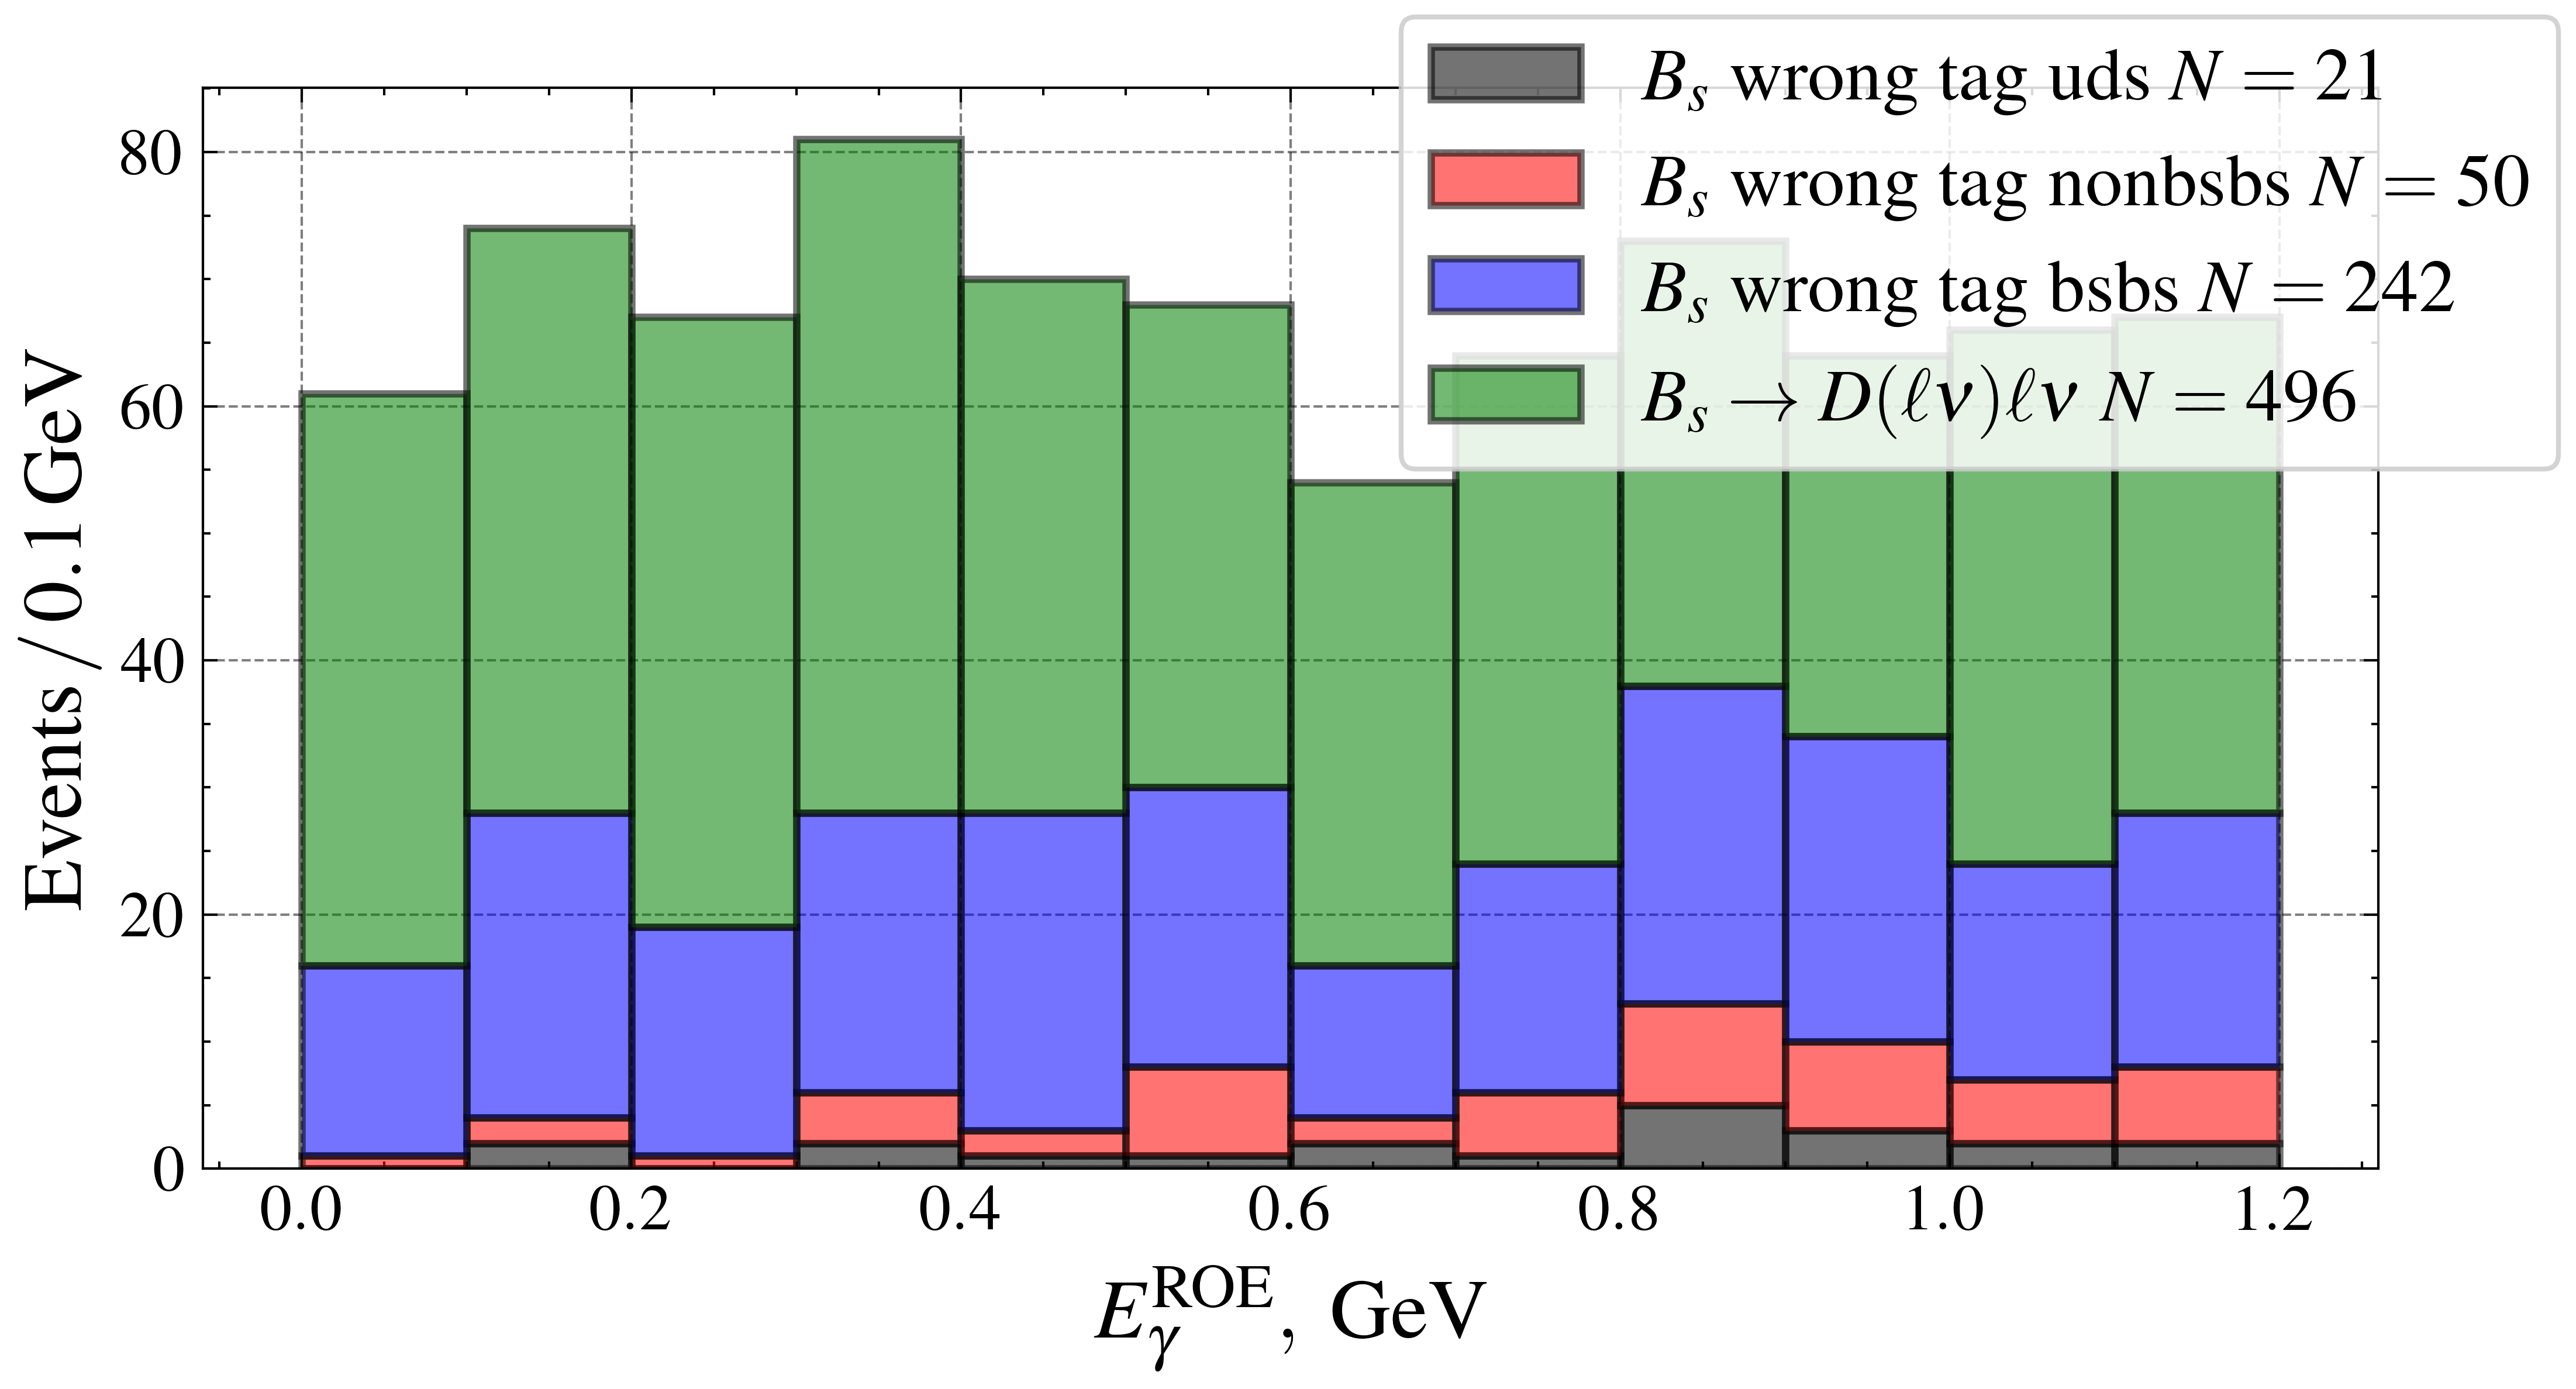

In [69]:
wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b - a) // wbin) + 2)

marker_labels = {
    1: r"$B_s \to D(\ell \nu)\ell \nu$",
    2: "nonbsbs",
    3: "Continuum",
    4: r"$B_s$ wrong tag uds",
    5: r"$B_s$ wrong tag nonbsbs",
    6: r"$B_s$ wrong tag bsbs"
}

stack_data = []
stack_labels = []
for marker in sorted(data["marker"].unique(), key=lambda x: (data["marker"] == x).sum()):
    subset = data[data["marker"] == marker]["E_gamma_in_ROE"]
    stack_data.append(subset)
    stack_labels.append(f"{marker_labels[marker]} $N = {len(subset)}$")

plt.hist(stack_data, bins=bins, stacked=True, alpha=0.55, edgecolor="black", linewidth=1.5, label=stack_labels)


plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}, \ \mathrm{GeV}$")
plt.ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), framealpha = 0.85)
plt.savefig("output/bg_E_ROE_stack.pdf", dpi=700)
plt.show()

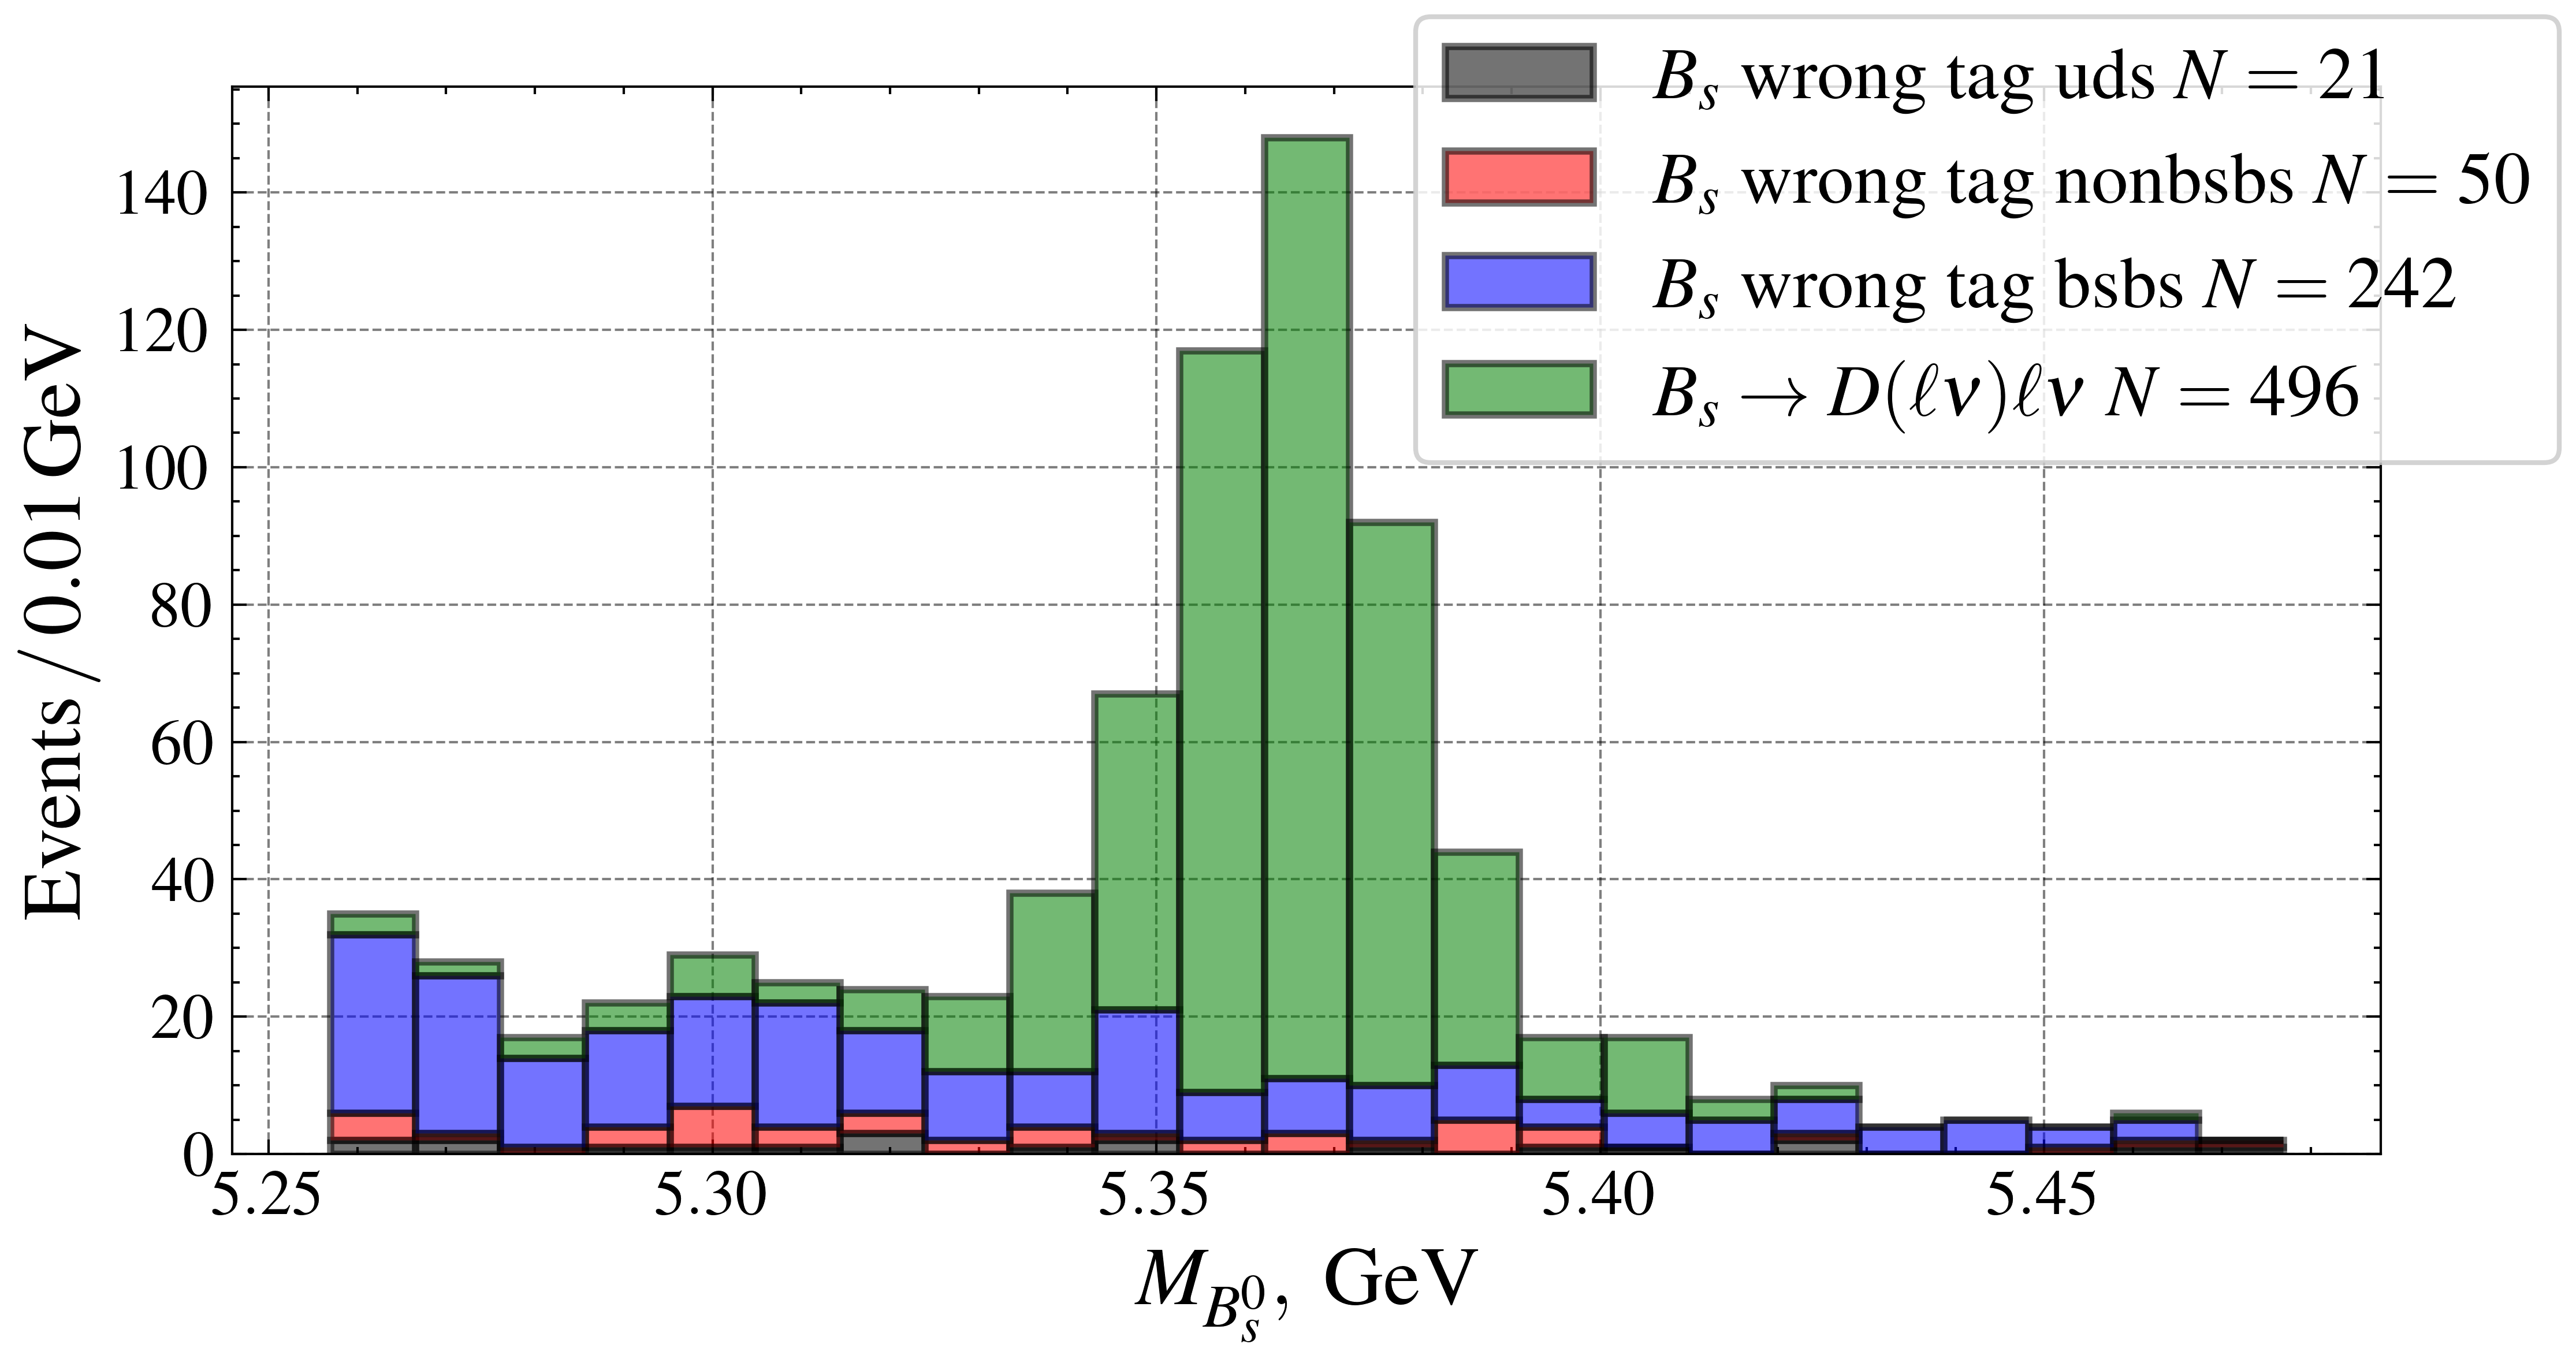

In [70]:
wbin = 0.01
a = Bs_m-0.11
b = Bs_m+0.11
bins = np.linspace(a, b, int((b - a) // wbin) + 2)

marker_labels = {
    1: r"$B_s \to D(\ell \nu)\ell \nu$",
    2: "nonbsbs",
    3: "Continuum",
    4: r"$B_s$ wrong tag uds",
    5: r"$B_s$ wrong tag nonbsbs",
    6: r"$B_s$ wrong tag bsbs"
}
stack_data = []
stack_labels = []
for marker in sorted(data["marker"].unique(), key=lambda x: (data["marker"] == x).sum()):
    subset = data[data["marker"] == marker]["MBtag"]
    stack_data.append(subset)
    stack_labels.append(f"{marker_labels[marker]} $N = {len(subset)}$")

plt.hist(stack_data, bins=bins, stacked=True, alpha=0.55, edgecolor="black", linewidth=1.5, label=stack_labels)


plt.xlabel(r"$M_{B_s^0}, \ \mathrm{GeV}$")
plt.ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), framealpha = 0.85)
plt.savefig("output/bg_M_BS0_stack.pdf", dpi=700)
plt.show()

In [71]:
X_new = data[columns]

bdt_scores = model.predict_proba(X_new)[:, 1] 

data["bdt_score"] = bdt_scores

selected_mask = data["bdt_score"] > FoM

selected_data = data[selected_mask]

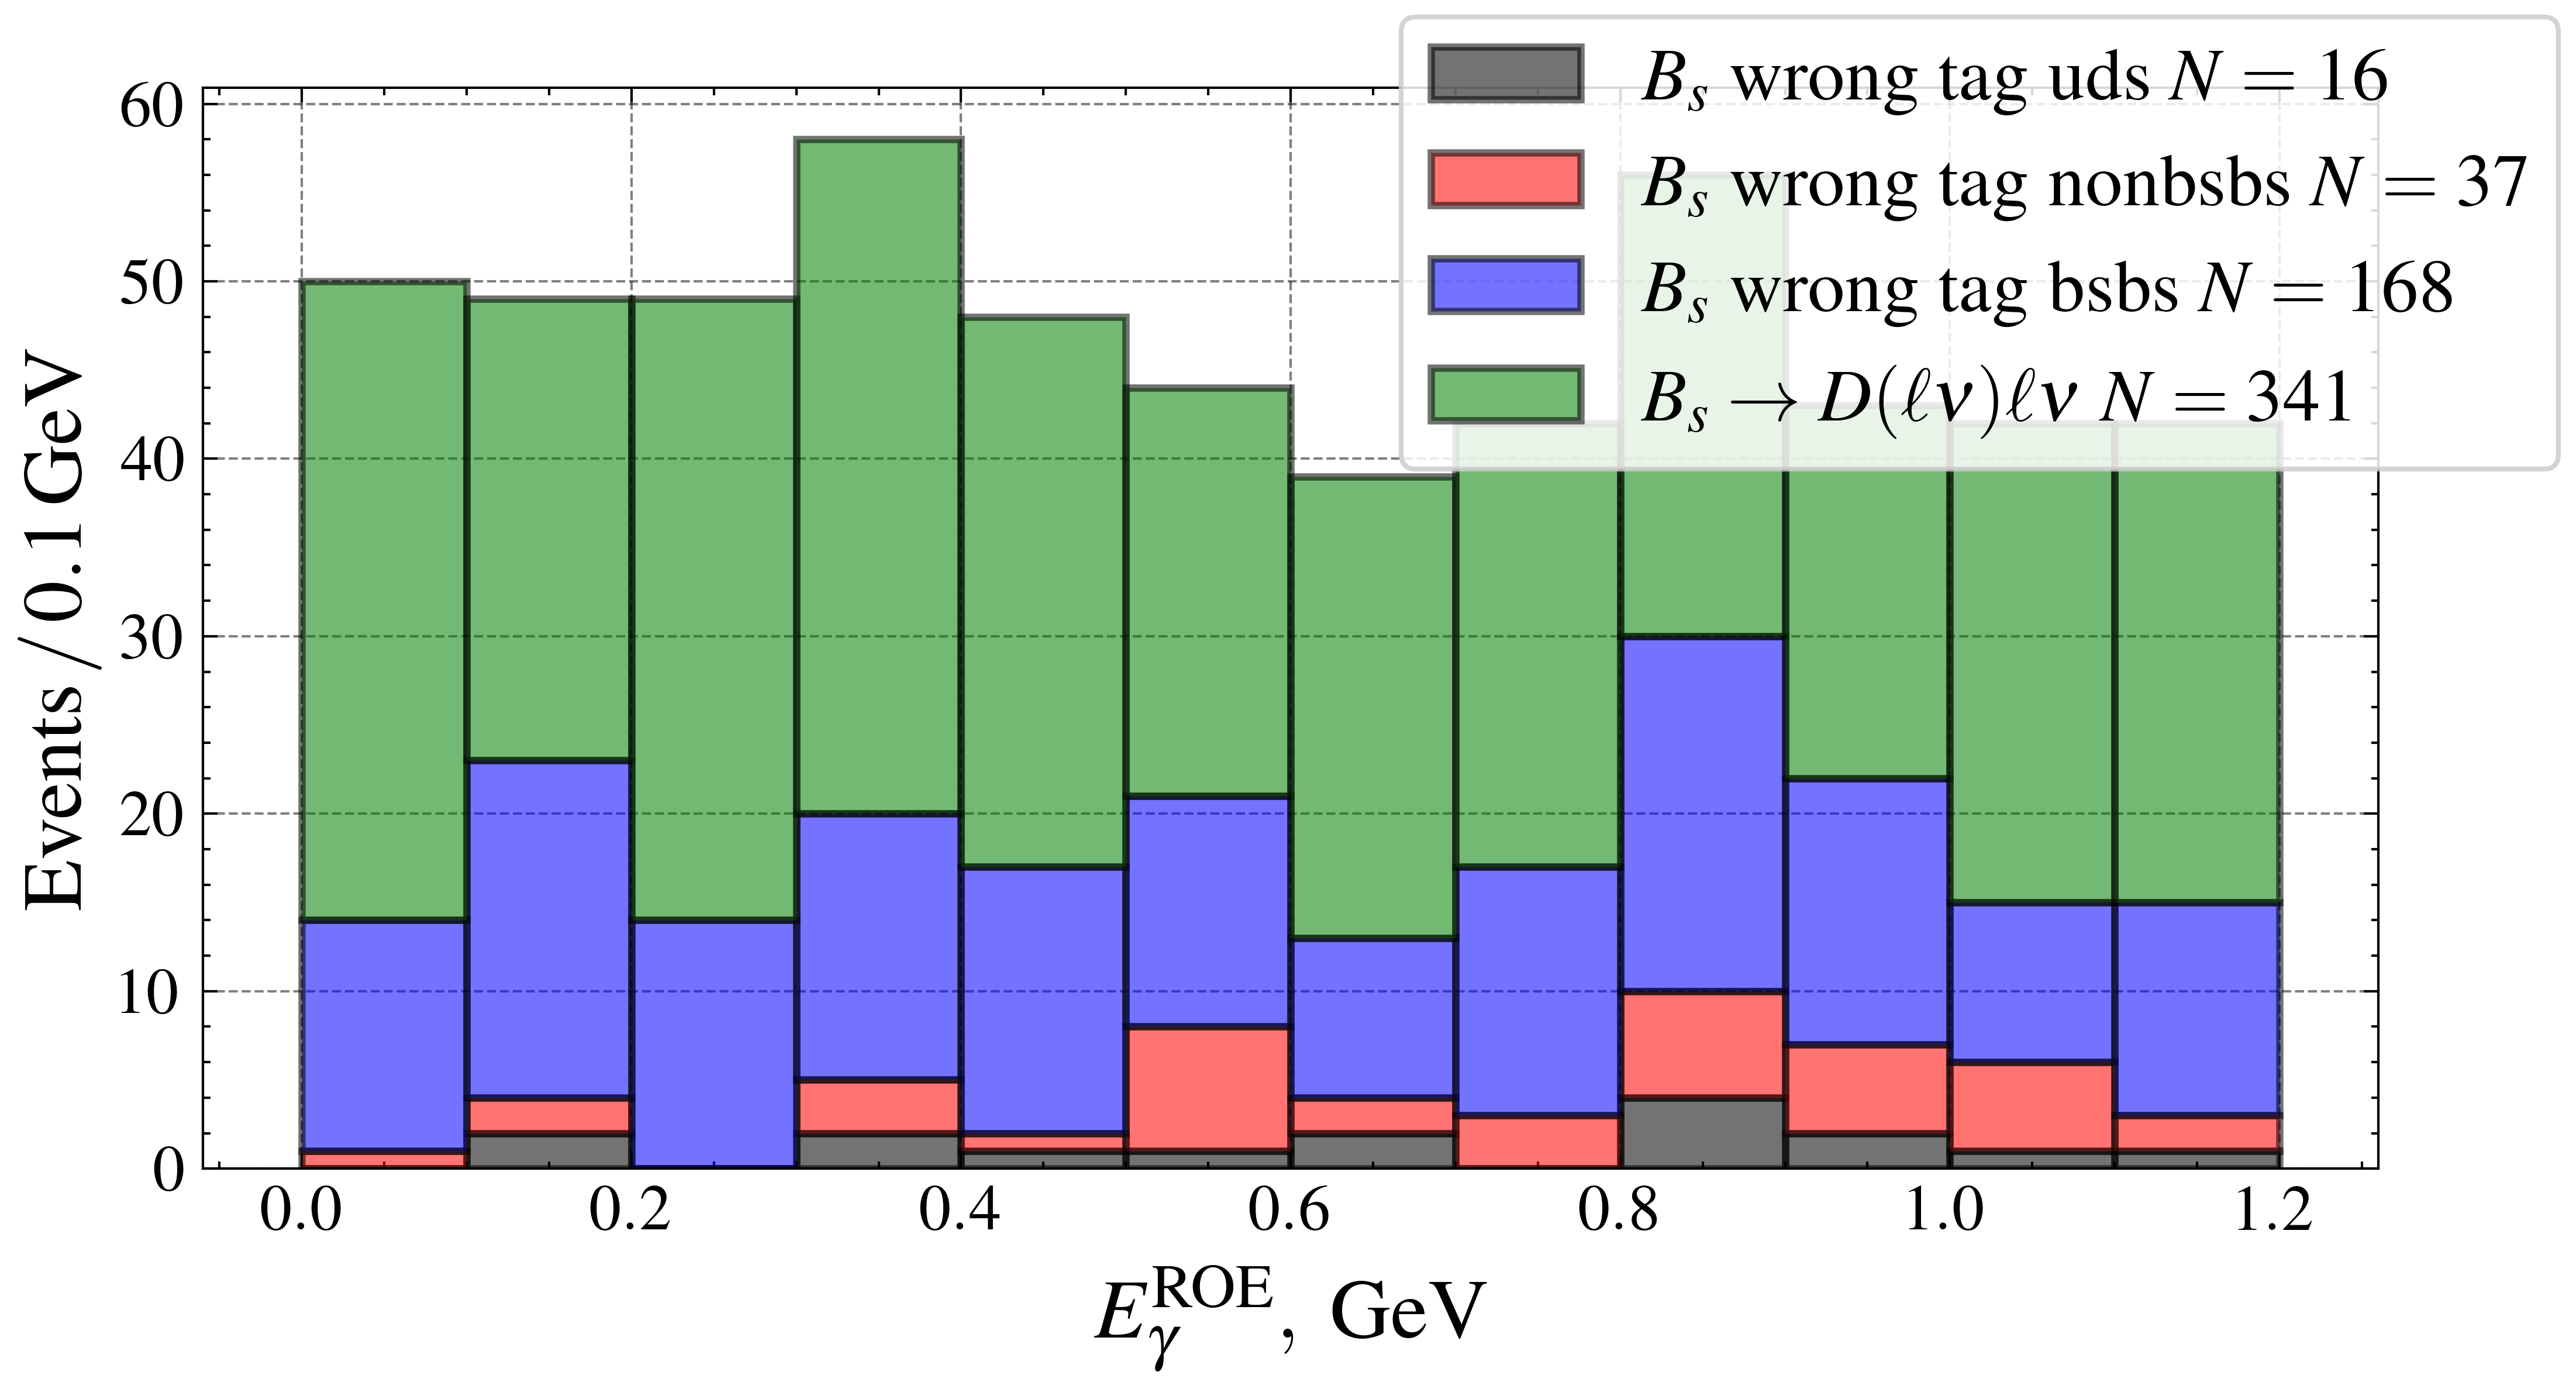

In [72]:
wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b - a) // wbin) + 2)

marker_labels = {
    1: r"$B_s \to D(\ell \nu)\ell \nu$",
    2: "nonbsbs",
    3: "Continuum",
    4: r"$B_s$ wrong tag uds",
    5: r"$B_s$ wrong tag nonbsbs",
    6: r"$B_s$ wrong tag bsbs"
}

stack_data = []
stack_labels = []
for marker in sorted(selected_data["marker"].unique(), key=lambda x: (selected_data["marker"] == x).sum()):
    subset = selected_data[selected_data["marker"] == marker]["E_gamma_in_ROE"]
    stack_data.append(subset)
    stack_labels.append(f"{marker_labels[marker]} $N = {len(subset)}$")

plt.hist(stack_data, bins=bins, stacked=True, alpha=0.55, edgecolor="black", linewidth=1.5, label=stack_labels)


plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}, \ \mathrm{GeV}$")
plt.ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), framealpha = 0.85)
plt.savefig("output/BDT_bg_E_ROE_stack.pdf", dpi=700)
plt.show()

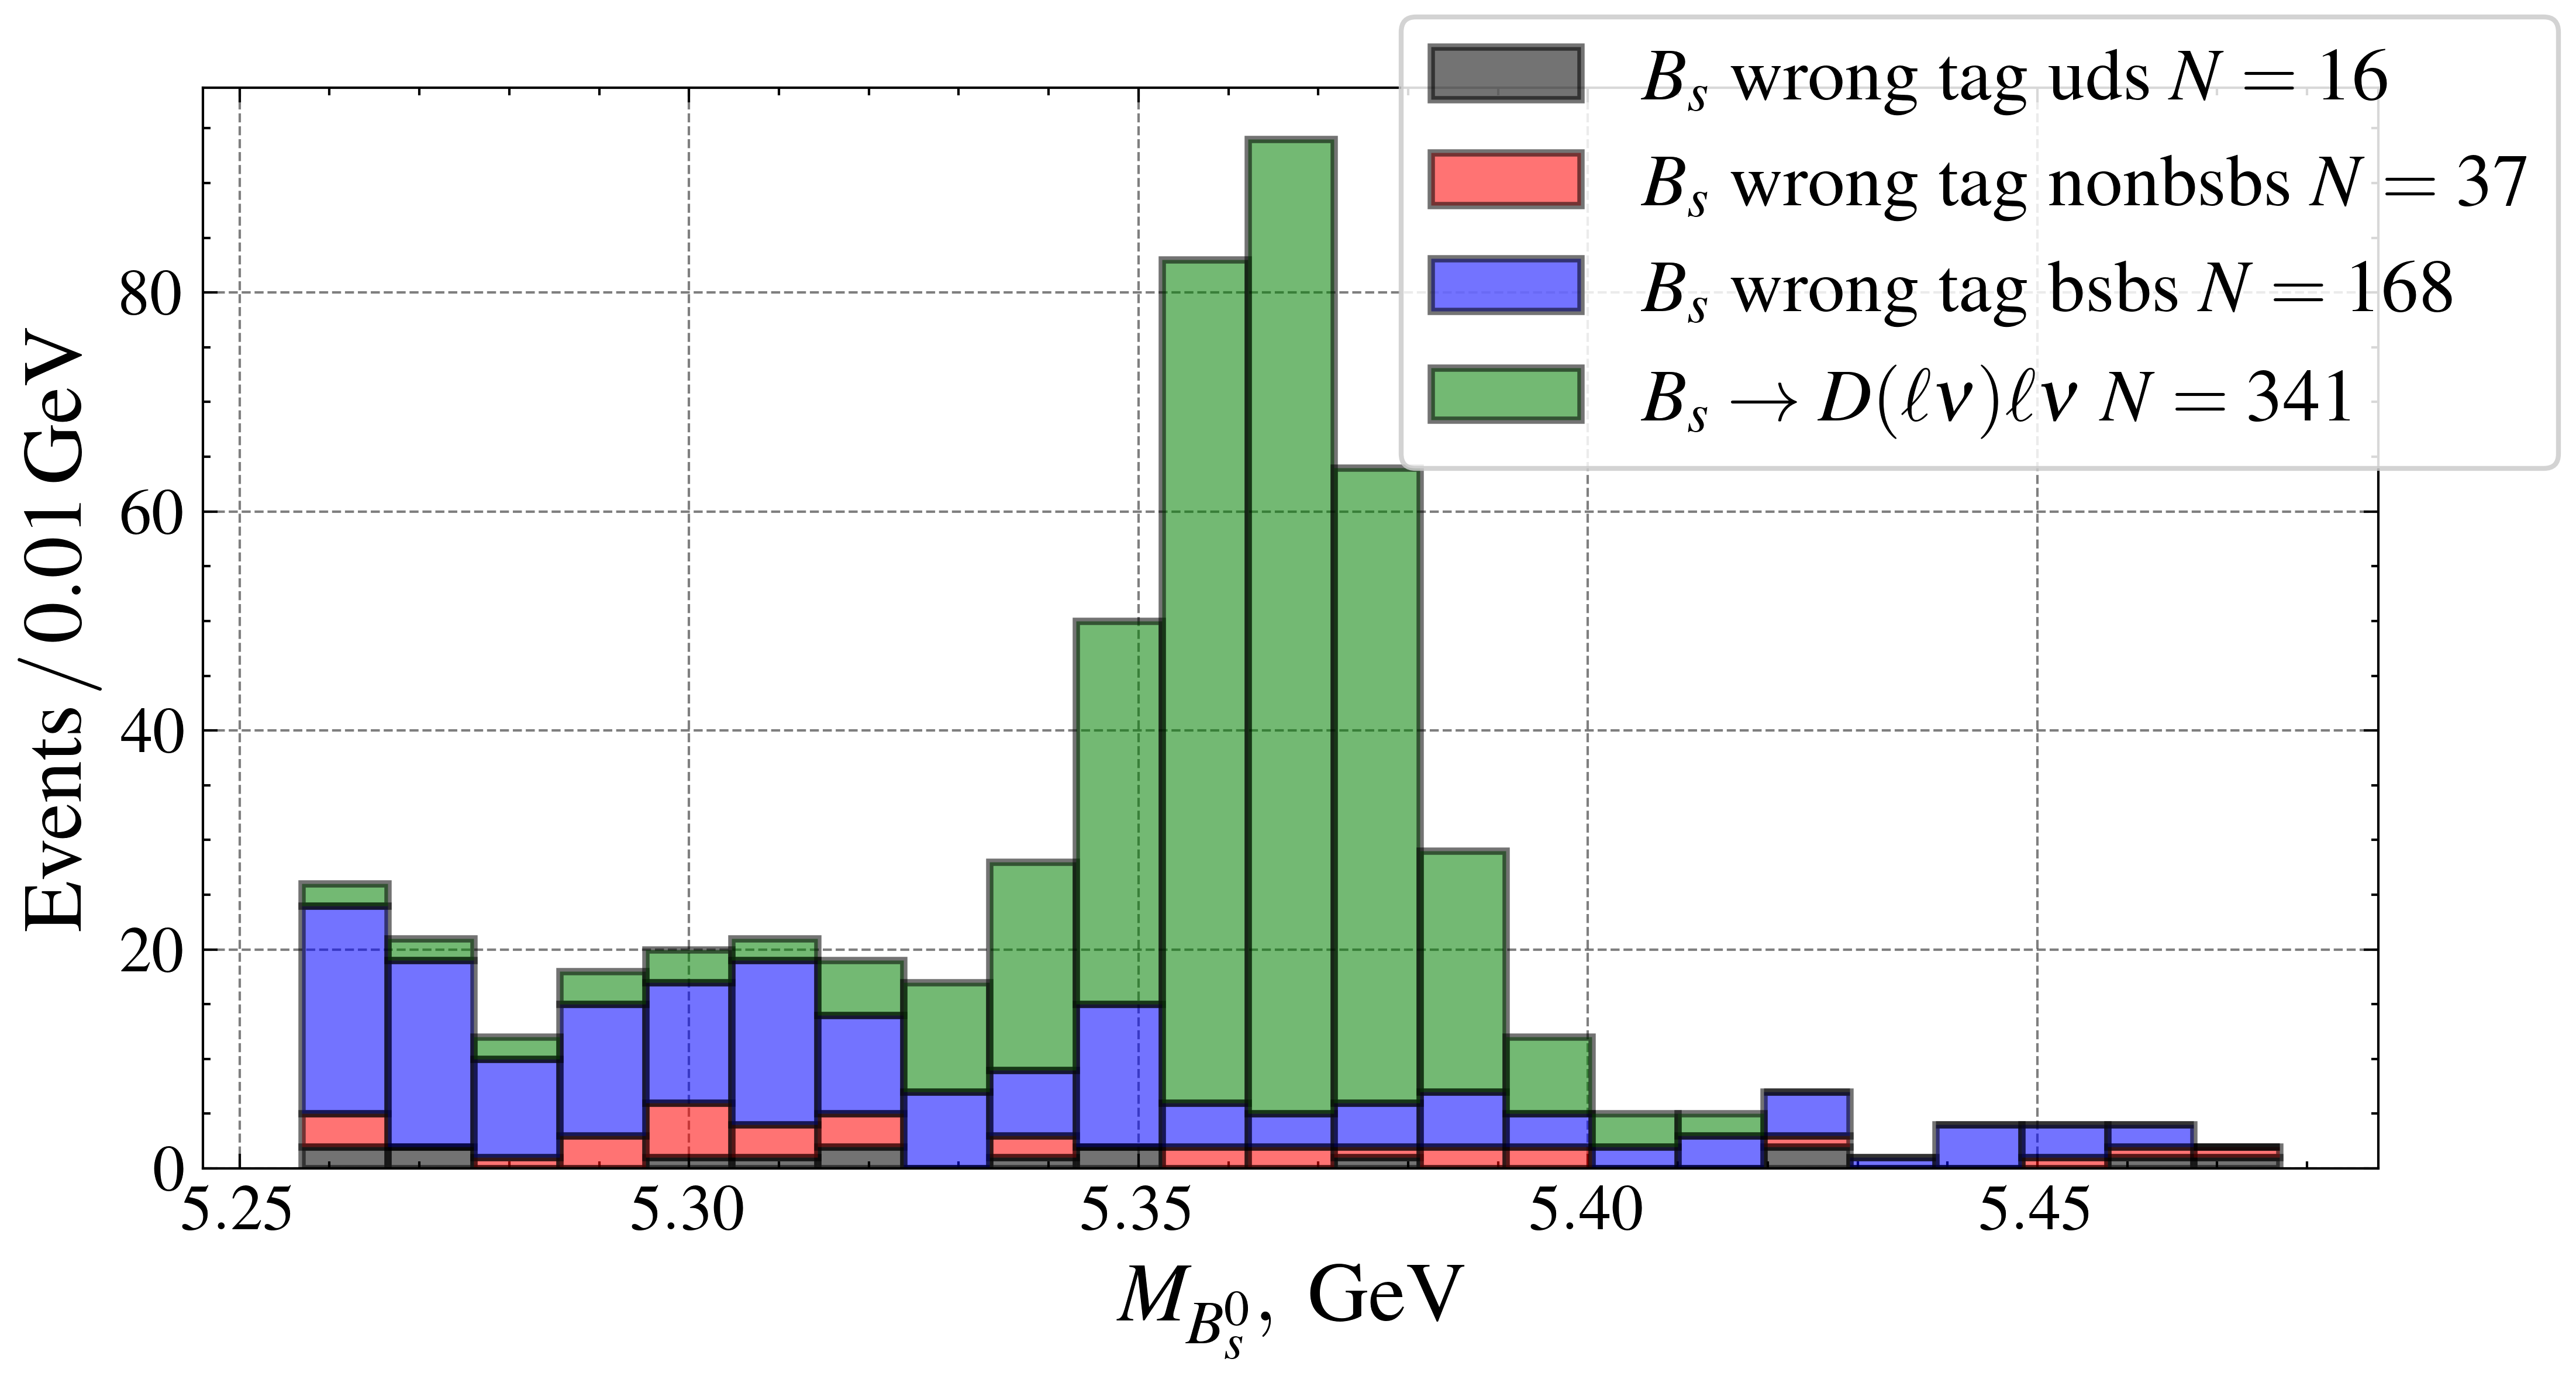

In [73]:
wbin = 0.01
a = Bs_m-0.11
b = Bs_m+0.11
bins = np.linspace(a, b, int((b - a) // wbin) + 2)

marker_labels = {
    1: r"$B_s \to D(\ell \nu)\ell \nu$",
    2: "nonbsbs",
    3: "Continuum",
    4: r"$B_s$ wrong tag uds",
    5: r"$B_s$ wrong tag nonbsbs",
    6: r"$B_s$ wrong tag bsbs"
}
nss = []
stack_data = []
stack_labels = []
for marker in sorted(selected_data["marker"].unique(), key=lambda x: (selected_data["marker"] == x).sum()):
    subset = selected_data[selected_data["marker"] == marker]["MBtag"]
    stack_data.append(subset)
    nss.append(len(subset))
    stack_labels.append(f"{marker_labels[marker]} $N = {len(subset)}$")

plt.hist(stack_data, bins=bins, stacked=True, alpha=0.55, edgecolor="black", linewidth=1.5, label=stack_labels)


plt.xlabel(r"$M_{B_s^0}, \ \mathrm{GeV}$")
plt.ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), framealpha = 0.85)
plt.savefig("output/BDT_bg_M_BS0_stack.pdf", dpi=700)
plt.show()

In [74]:
N1 = nss[0] + nss[1] + nss[2]
N2 = nss[3]

In [75]:
def gen_toy_nd(pdf_func, bounds, size=10000, grid_points=50):
    ndim = len(bounds)
    samples = []

    grids = [np.linspace(a, b, grid_points) for a, b in bounds]
    meshes = np.meshgrid(*grids, indexing='ij')
    Z = pdf_func(meshes)
    ymax = np.max(Z)

    while len(samples) < size:
        x_trial = [np.random.uniform(a, b) for a, b in bounds]
        y_trial = np.random.uniform(0, ymax)

        x_array = [np.array([xi]) for xi in x_trial]

        if y_trial <= pdf_func(x_array):
            samples.append(x_trial)

    return np.array(samples)


In [76]:
def gen_toy(pdf_func, a, b, size=10000):
    samples = []
    ymax  = np.max(pdf_func(np.linspace(a, b, 1000)))
    while len(samples) < size:
        x_trial = np.random.uniform(a, b)
        y_trial = np.random.uniform(0, ymax)
        try:
            if y_trial <= pdf_func(x_trial):
                samples.append(x_trial)
        except: continue
    return np.array(samples)


In [77]:
def f_E_g_lep_gamma(x, *, lam, k, theta):
    from scipy.special import gamma
    x = np.where(x <= 0.000001, 0.0001, x)
    x = x*lam
    base = (1 / (gamma(k) * theta**k)) * x**(k - 1) * np.exp(-x / theta)
    return base
with open("output/sig_fit.json", "r") as f:
    rez0 = dict(json.load(f))
    del rez0["norm"]

In [78]:
def f_E_g_lep_gamma(x, k, theta):
    from scipy.special import gamma
    x = x
    base = (1 / (gamma(k) * theta**k)) * x**(k - 1) * np.exp(-x / theta)
    return base
def f_sig(x):
    k, theta, mu, sig1, sig2, A = rez0.values()
    return f_E_g_lep_gamma(x[0], k, theta)*(gaussian(x[1], mu, sig1)*A + gaussian(x[1], mu, sig2)*(1 - A))

In [79]:
bsbs = hist_approx().load_hist("output/bsbs.json")
ubs = hist_approx().load_hist("output/ubs.json")

In [80]:
toy_pdf = lambda x: bsbs.get_pdf(x)*N2/(N1+N2) + ubs.get_pdf(x)*N1/(N1+N2)
ds_toy = gen_toy_nd(toy_pdf, bounds=[[0, 1.2], [5.25, 5.5]], size=int((N1+N2)/6), grid_points=100)

In [81]:
wbin_x, a_x, b_x = 0.1, 0, 1.2
wbin_y, a_y, b_y = 0.01, 5.25, 5.5
bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x))
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y))
bin_centers = [0.5 * (b[:-1] + b[1:]) for b in (bins_x, bins_y)]
bin_centers = np.meshgrid(*bin_centers, indexing='ij')


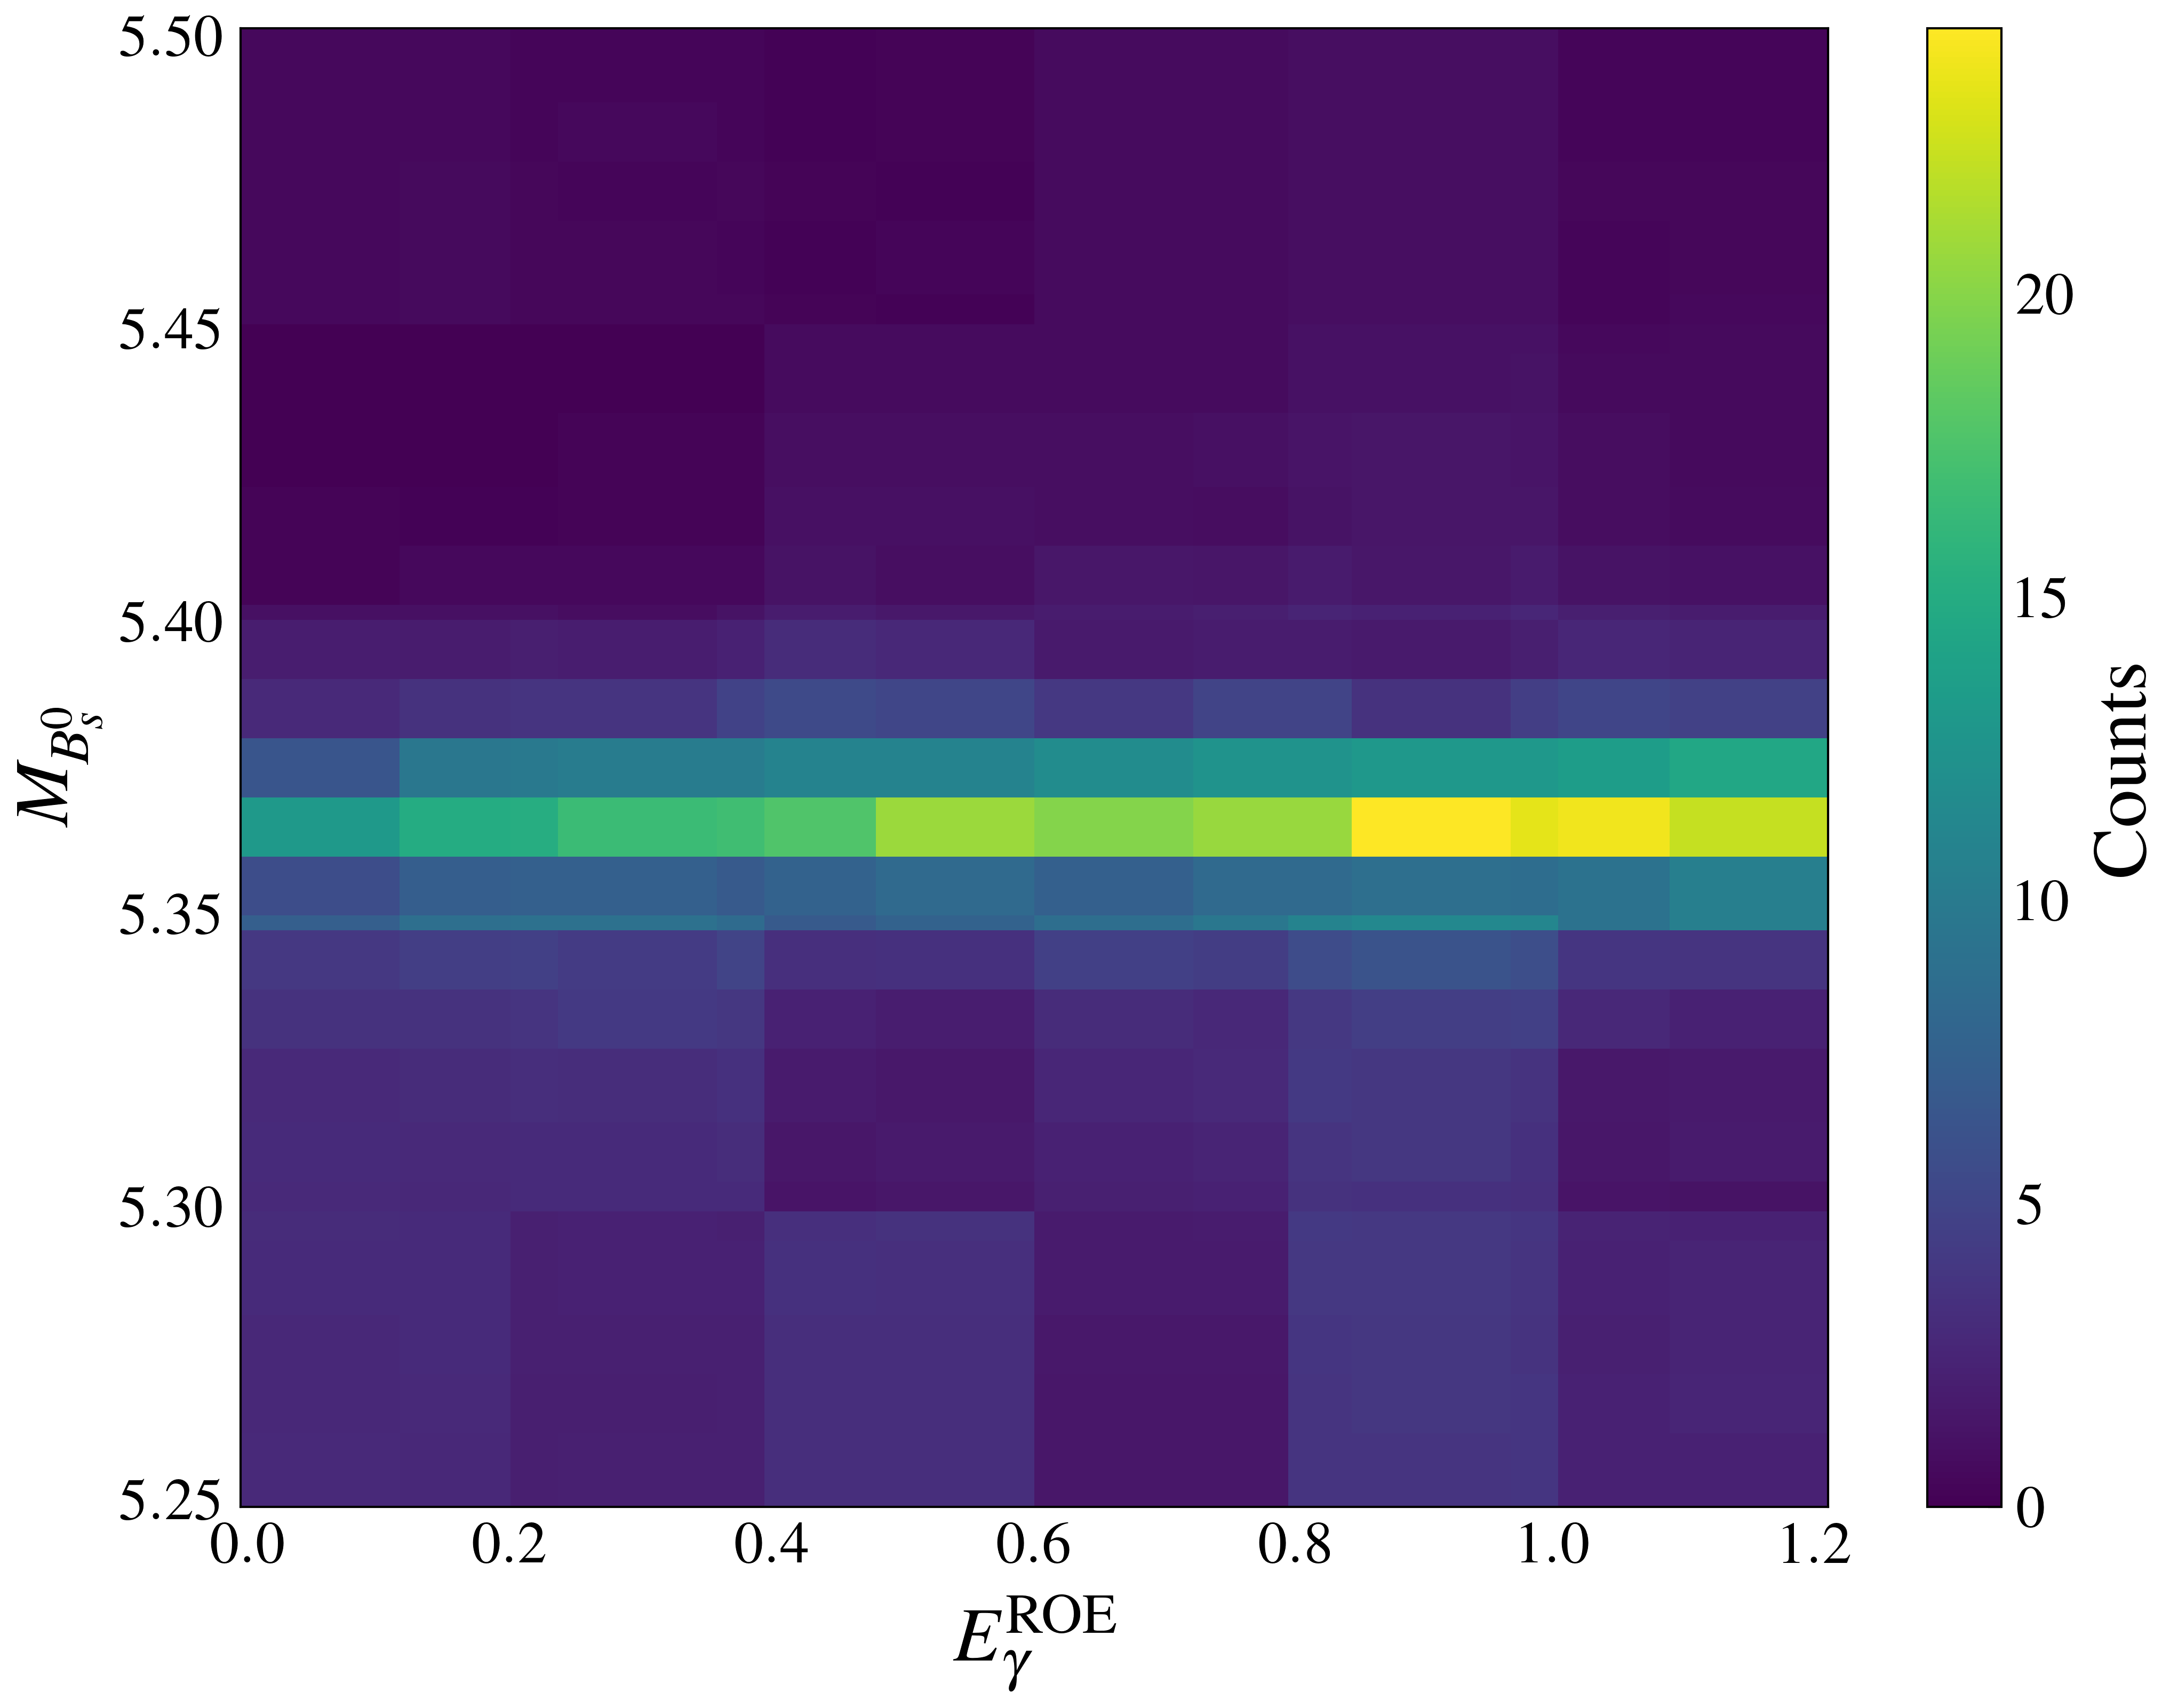

In [82]:
x = np.linspace(a_x, b_x, 100)
y = np.linspace(a_y, b_y, 100)
X, Y = np.meshgrid(x, y, indexing='ij')
val = toy_pdf([X, Y])

plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(X, Y, val)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel(r"$M_{B_s^0}$")
plt.colorbar(pmesh, label="Counts")
plt.show()

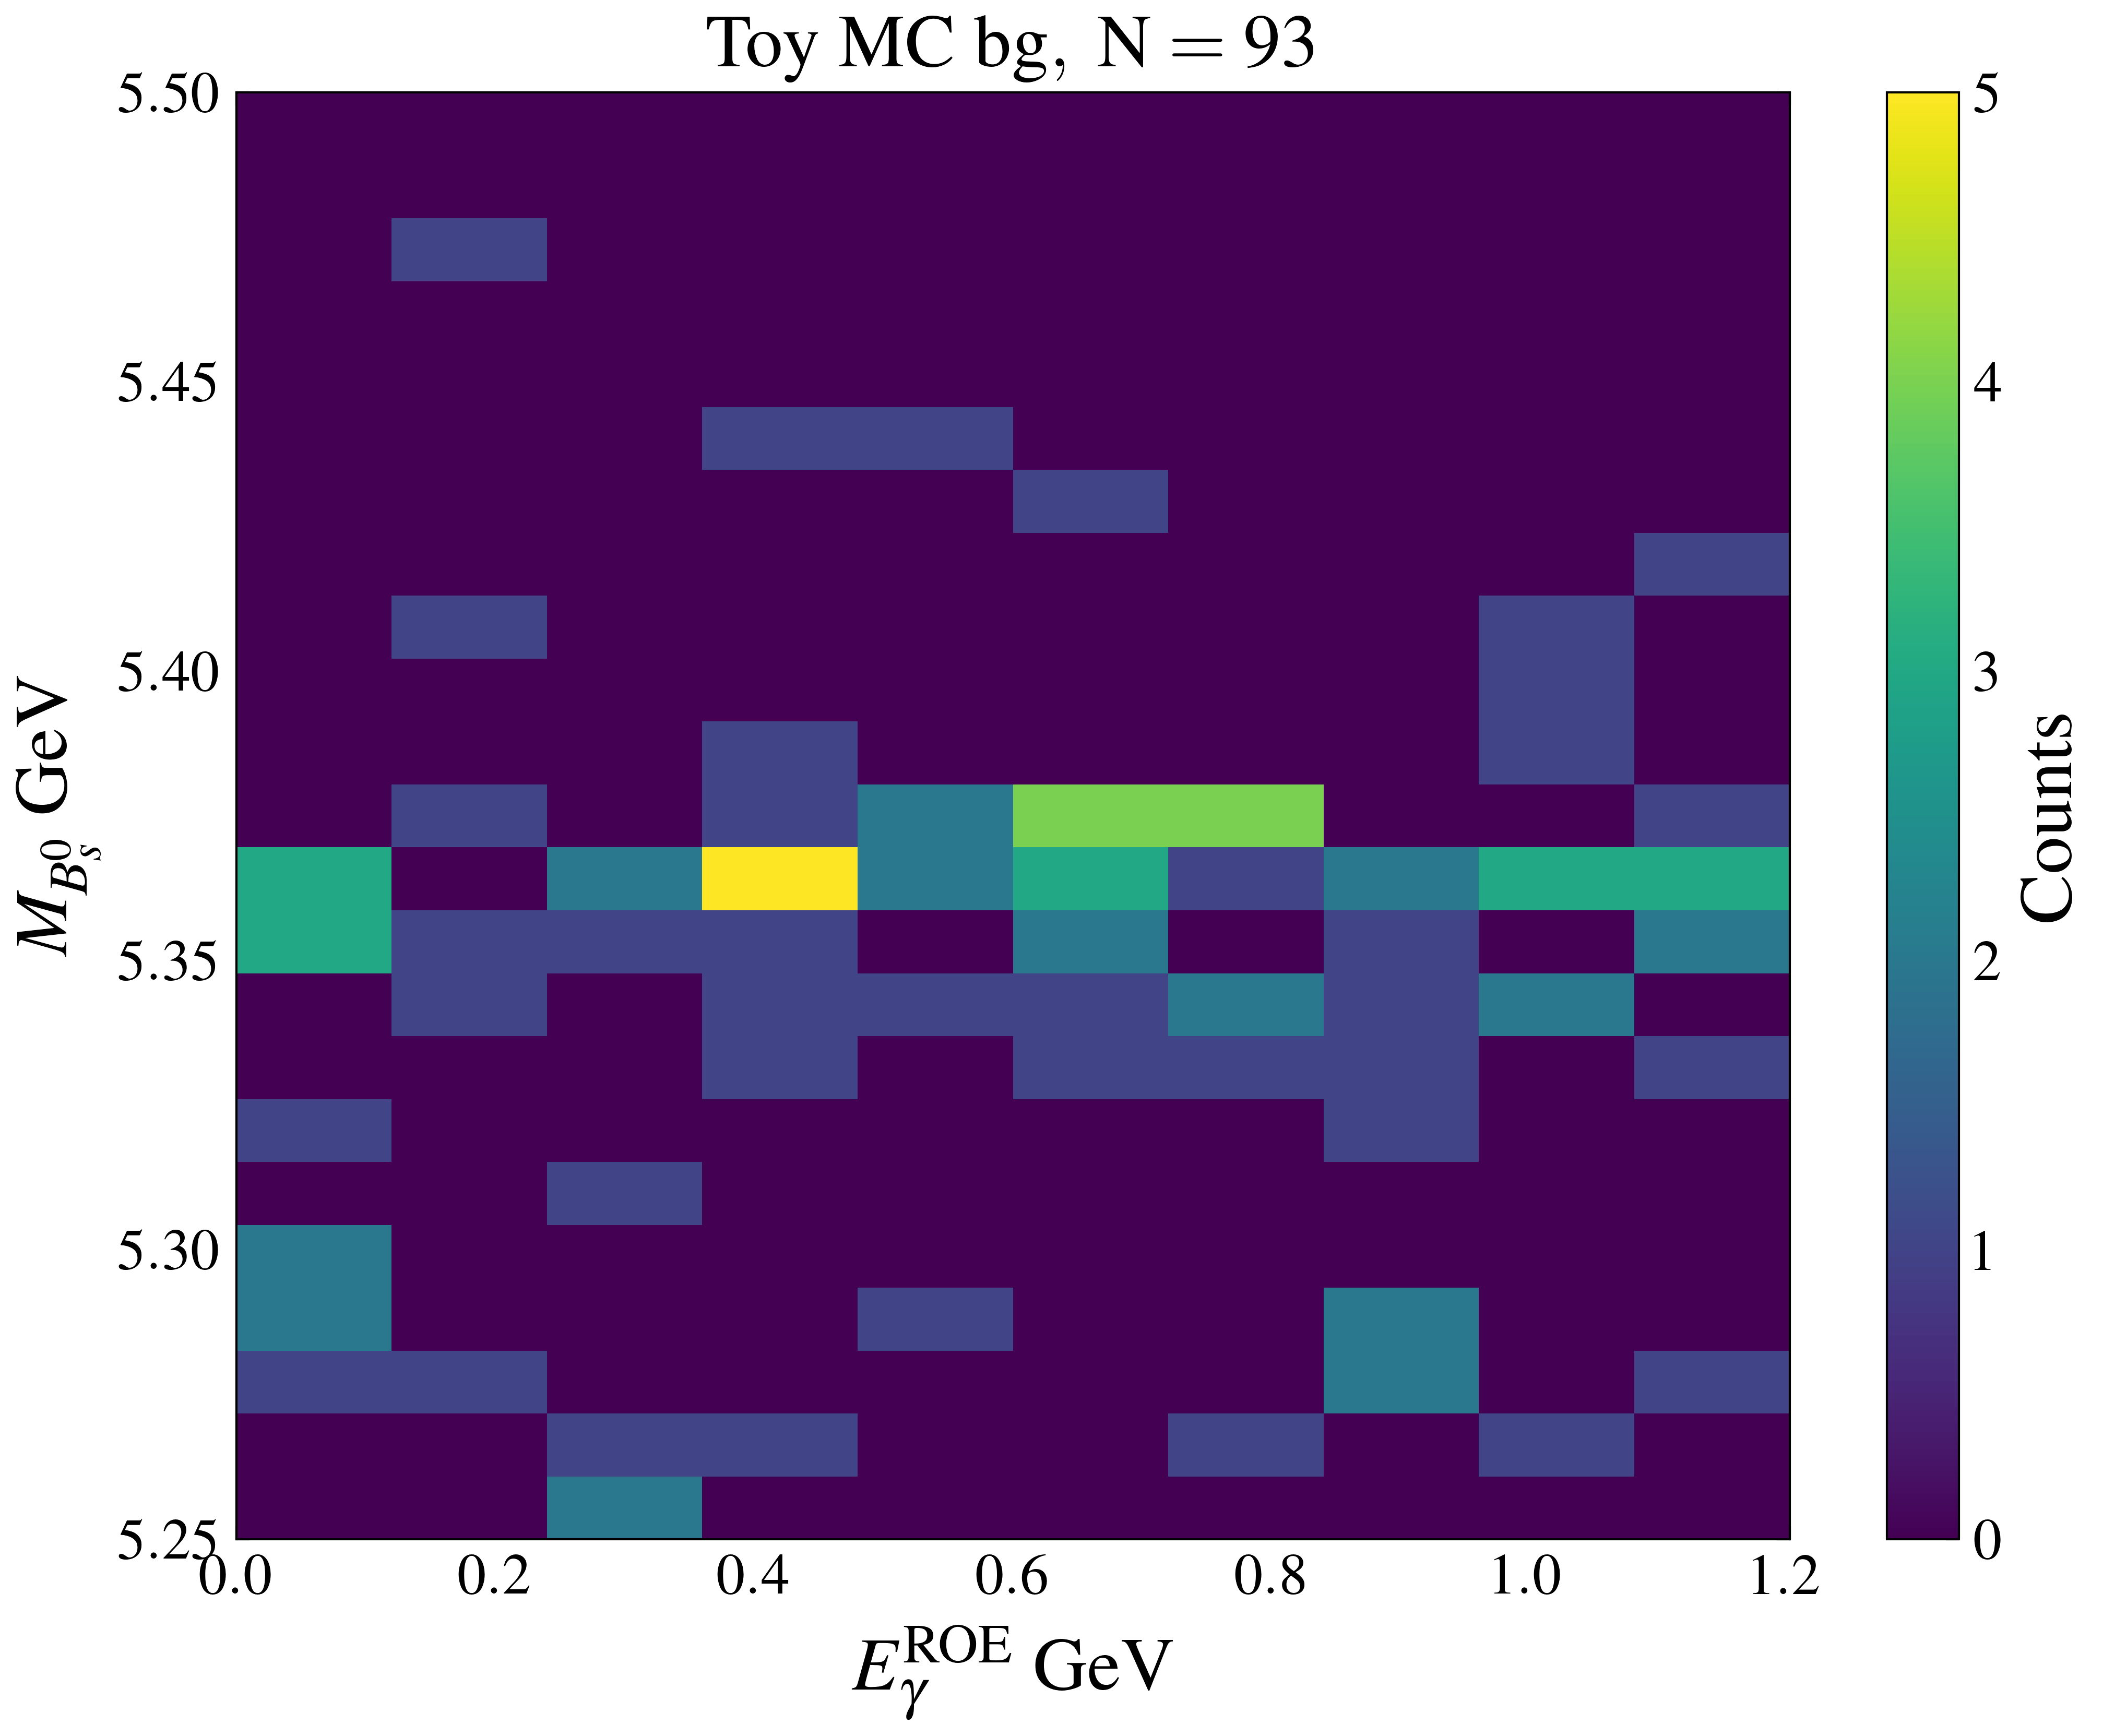

In [83]:

plt.figure(figsize=(8, 6))

h_sig = plt.hist2d(*ds_toy.T, bins=[bins_x, bins_y])

plt.xlabel(r"$E_\gamma^{\mathrm{ROE}} \ \mathrm{GeV}$")
plt.ylabel(r"$M_{B_s^0} \ \mathrm{GeV}$")
plt.title(rf"$\mathrm{{Toy \ MC \ bg, \ N}}={int((N1+N2)/6)}$")
plt.colorbar(h_sig[3], label='Counts')
plt.savefig("output/toy_mc_hist2d.pdf", dpi=700)

In [84]:
def f_fit (x, *, w0, w1, stak = False):
    A0 = w0
    A1 = (1 - w0) * w1
    A2 = 1 - A0 - A1
    if not stak:
        return f_sig(x)*A0 + bsbs.get_pdf(x)*A1 + ubs.get_pdf(x)*A2
    return f_sig(x)*A0, bsbs.get_pdf(x)*A1, ubs.get_pdf(x)*A2

In [85]:
def f_fit (x, *, N_sig, N_bsbs, N_ubs, stak = False):
    if not stak:
        return (f_sig(x)*N_sig + bsbs.get_pdf(x)*N_bsbs + ubs.get_pdf(x)*N_ubs)/(N_sig + N_bsbs + N_ubs)
    return f_sig(x)*N_sig, bsbs.get_pdf(x)*N_bsbs, ubs.get_pdf(x)*N_ubs

In [ ]:
def max_lik_ext(f, x, args0, a=0, b=0, bounds=None, err_need=False):
    
    from scipy.special import factorial
    from numpy import log, exp, power, pi, e
    from numpy import sum as summ
    def poisson(x, n):
        if n > 100:
            return exp(-x)*power(e*x/n, n)/(2*pi*n)
        return exp(-x)*power(x, n)*power(factorial(n), -1)
    
    
    if a == b:
        def df(*args):
            current_args = {k: v for k, v in zip(args0.keys(), args)}
            N_args = sum([v for k, v in current_args.items() if k[0] == "N"])
            return -2*(summ(log(f(x, **current_args)))) - 2*log(poisson(len(x.T),  N_args))
    else:
        def df(*args):
            current_args = {k: v for k, v in zip(args0.keys(), args)}
            N_args = sum([v for k, v in current_args.items() if k[0] == "N"])
            return -2*(summ(log(f(x, **current_args)/normalization(lambda x: f(x.T, **current_args), a, b, func=True, n_points=300)))) - 2*log(poisson(len(x.T), N_args))

    from iminuit import Minuit
    minuit = Minuit(df, *[args0[k] for k in args0], name=list(args0.keys()))

    if bounds:
        for k, bnd in bounds.items():
            minuit.limits[k] = bnd

    minuit.migrad()

    rez = minuit.values.to_dict()
    errs = minuit.errors.to_dict() if err_need else None


    if err_need:
        return {k: v for k, v in rez.items() if k != "norm"}, errs
    return {k: v for k, v in rez.items() if k != "norm"}


C:\Users\marc\AppData\Local\Temp\ipykernel_18972\3256581085.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fit_proj_x = [np.trapz(src, y_centers, axis=1) * wbin_x for src in sources]
C:\Users\marc\AppData\Local\Temp\ipykernel_18972\3256581085.py:69: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fit_proj_y = [np.trapz(src, x_centers, axis=0) * wbin_y for src in sources]


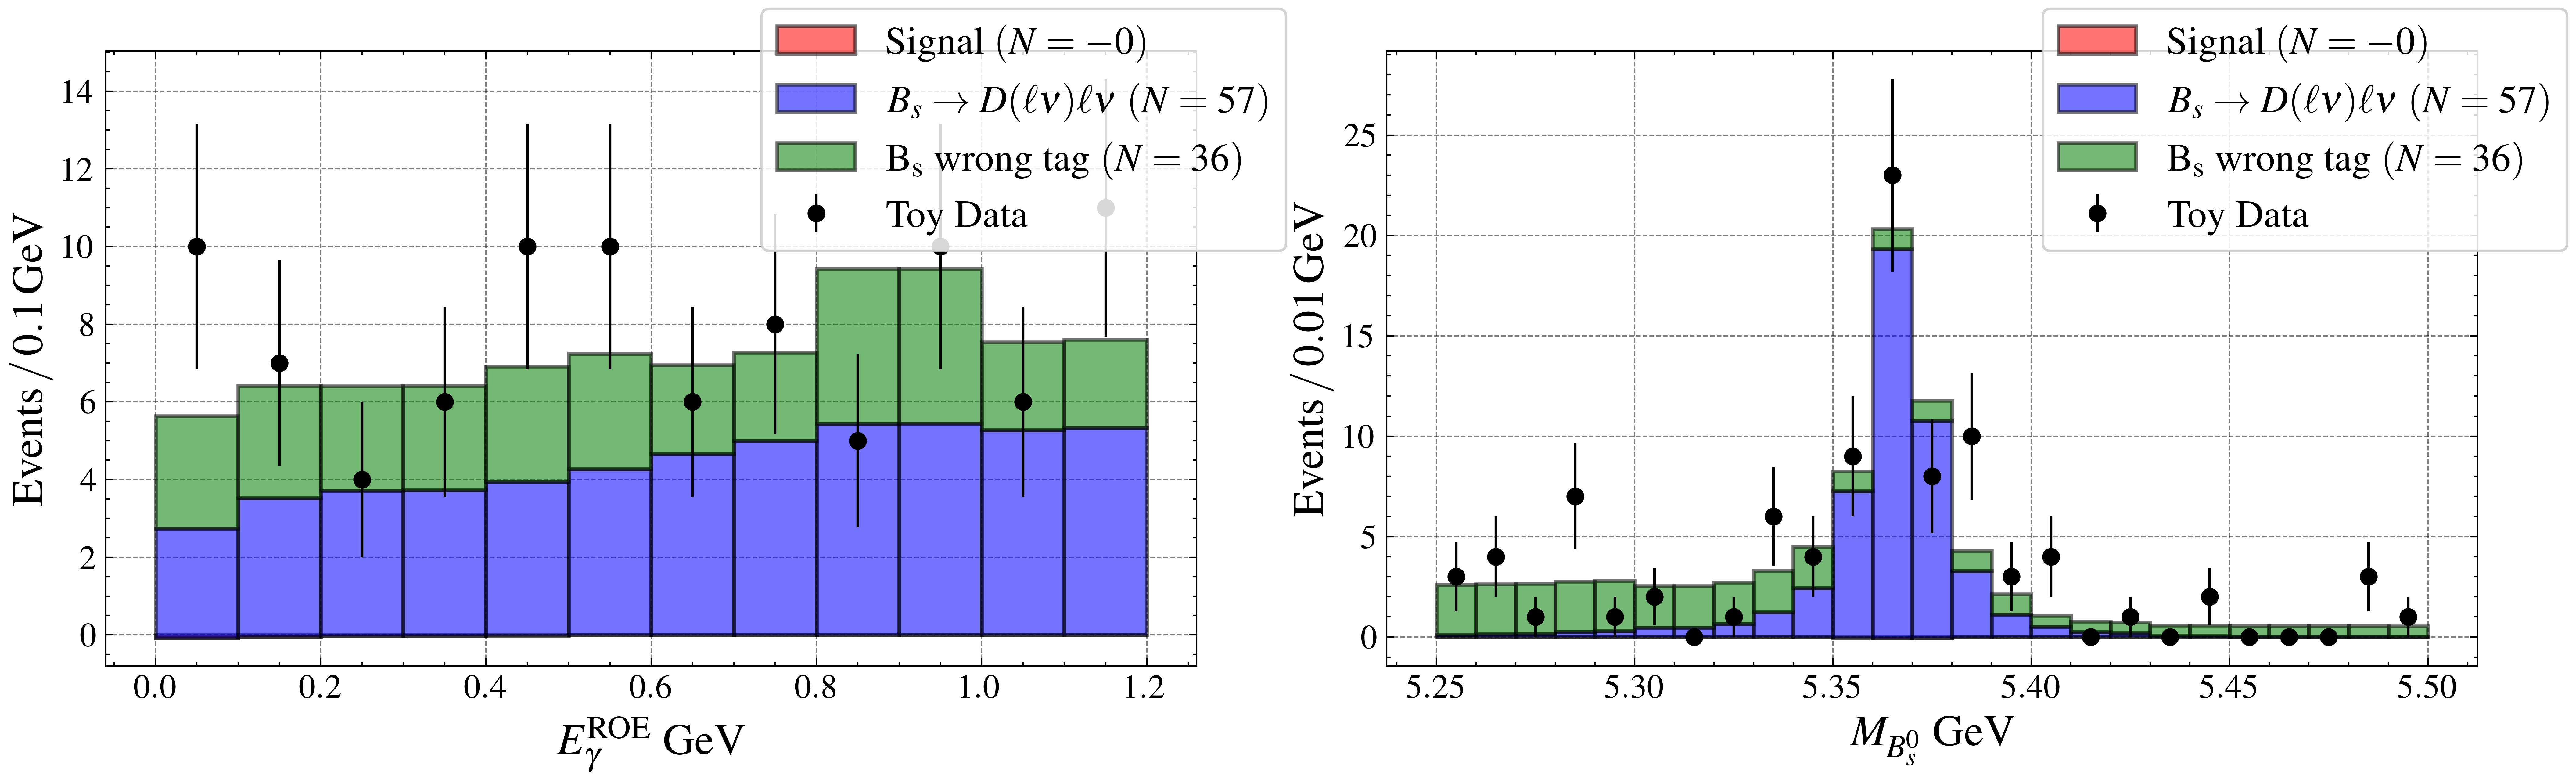

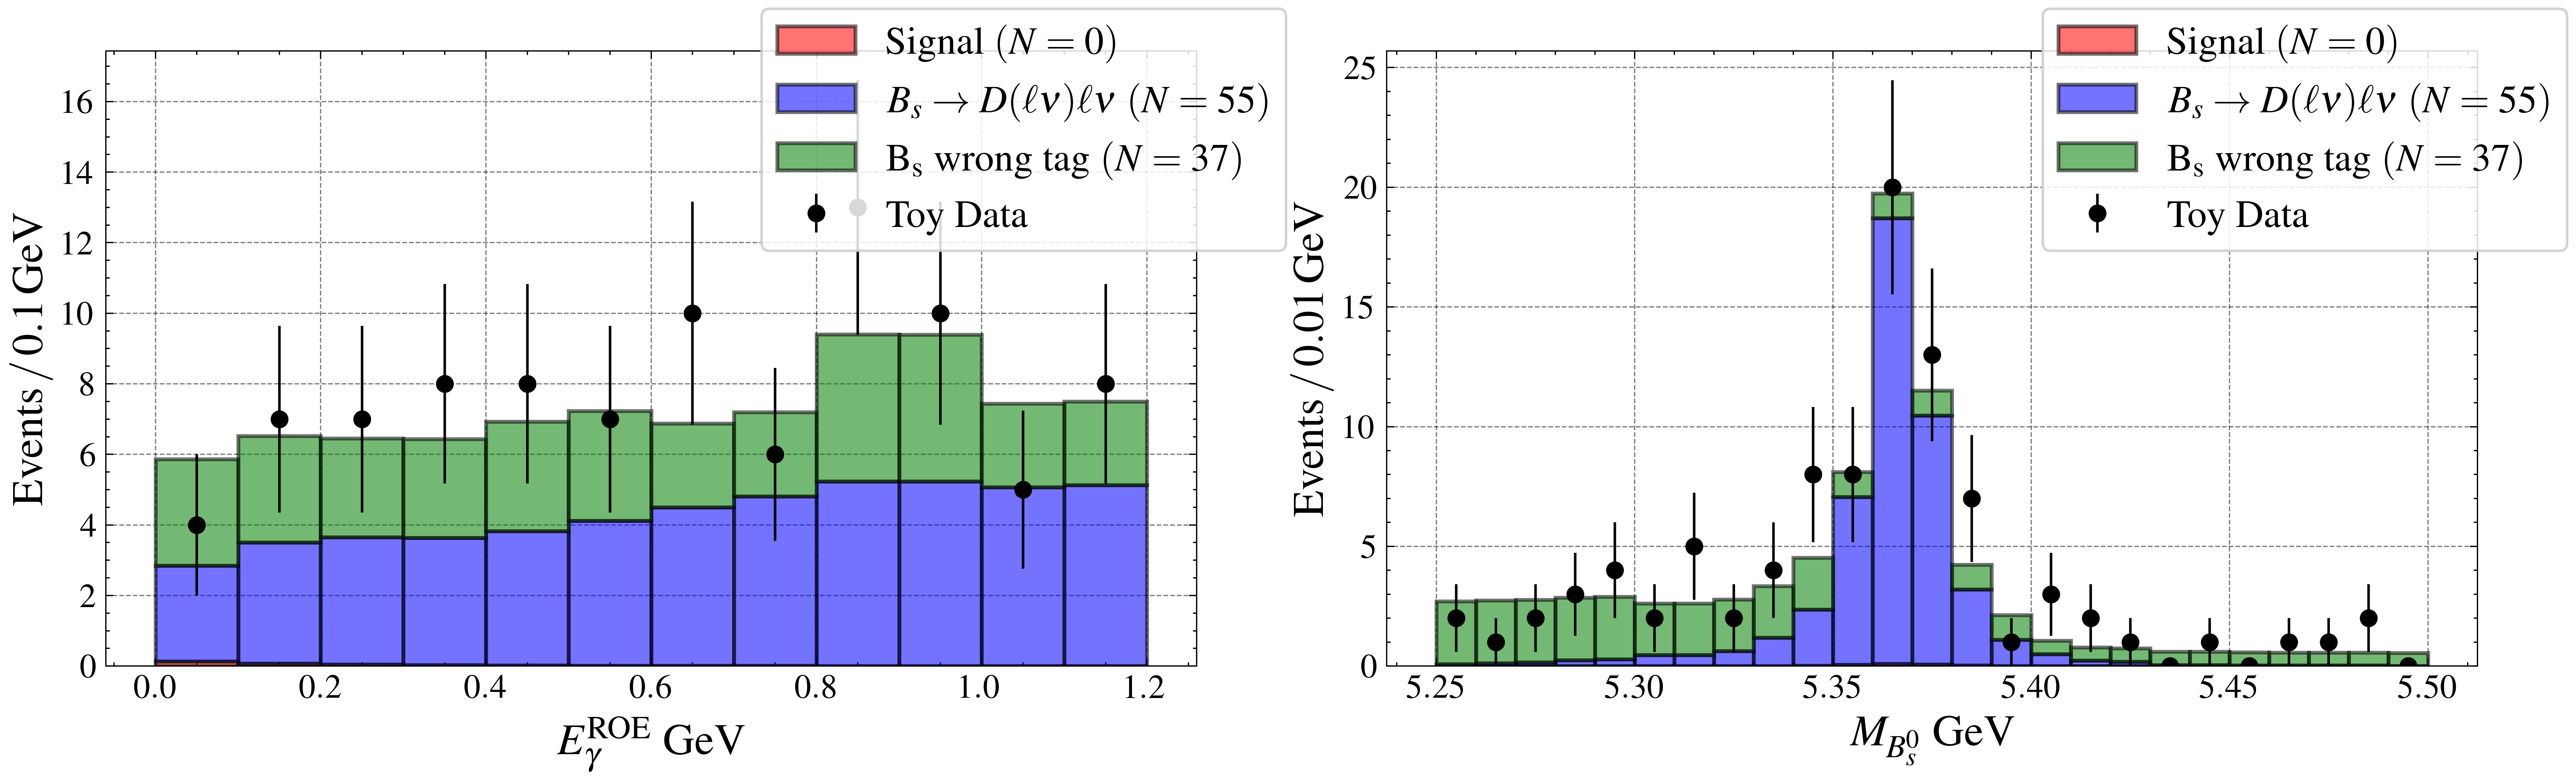

C:\Users\marc\AppData\Local\Temp\ipykernel_18972\2895196731.py:13: RuntimeWarning: invalid value encountered in log
  return -2*(summ(log(f(x, **current_args)))) - 2*log(poisson(len(x.T),  N_args))


In [87]:
wbin_x, a_x, b_x = 0.1, 0, 1.2
wbin_y, a_y, b_y = 0.01, 5.25, 5.5
bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x)+2)
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y)+2)

A_list = []
A_errors = []
plt_s = (12/1.7, 6/1.7)
pull_s = (12/6, 6/6)

n_toys = 1000
fit_results = []

for i in range(n_toys):
    toy_sample = gen_toy_nd(
        toy_pdf,
        bounds=[[0, 1.2], [5.25, 5.5]],
        size=int((N1+N2)/6),
        grid_points=100
    )
    
    rez, errors = max_lik_ext(
        f_fit,
        toy_sample.T,
        {"N_sig": 0*(N1+N2)/6, "N_bsbs": 0.5*(N1+N2)/6, "N_ubs": 0.5*(N1+N2)/6},
        bounds={"N_sig": (-(N1+N2)/6, N1+N2), "N_bsbs": (-(N1+N2)/6, N1+N2), "N_ubs": (-(N1+N2)/6, N1+N2)},
        err_need=True
    )

    # Пересчёт в физические A0, A1, A2

    N_signal = rez["N_sig"]
    N_bsbs = rez["N_bsbs"]
    N_ubs = rez["N_ubs"]
    
    fit_results.append(rez)
    A_list.append([N_signal, N_bsbs, N_ubs])
    # Ошибки пересчитываются через производные (пока оставим как для w0, w1)
    A_errors.append([errors.get("N_sig", np.nan), errors.get("N_bsbs", np.nan), errors.get("N_ubs", np.nan)])

    # --- рисование только первых 2 игрушек ---
    if i >= 2:
        continue

    fig, axs = plt.subplots(1, 2, figsize=(2*plt_s[0], plt_s[1]*1.25))
    x_centers = 0.5 * (bins_x[:-1] + bins_x[1:])
    y_centers = 0.5 * (bins_y[:-1] + bins_y[1:])
    X, Y = np.meshgrid(x_centers, y_centers, indexing='ij')

    counts, _ = np.histogram(toy_sample.T[0], bins=bins_x)
    sources = f_fit([X, Y], **rez, stak=True)
    fit_proj_x = [np.trapz(src, y_centers, axis=1) * wbin_x for src in sources]

    labels = [
        rf"$\mathrm{{Signal}}\ (N={N_signal:.0f})$",
        rf"$B_s \to D(\ell \nu)\ell \nu\ (N={N_bsbs:.0f})$",
        rf"$\mathrm{{B_s\ wrong \ tag}}\ (N={N_ubs:.0f})$"
    ]

    ax = axs[0]
    ax.errorbar(x_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Toy Data")
    ax.hist([x_centers]*len(fit_proj_x), bins=bins_x, weights=fit_proj_x,
            stacked=True, alpha=0.55, edgecolor="black", linewidth=1.5, label=labels)
    ax.set_ylabel(fr'$\mathrm{{Events}}\,/\,{wbin_x}\,\mathrm{{GeV}}$')
    ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE}\ \mathrm{GeV}$')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), framealpha=0.85)

    counts, _ = np.histogram(toy_sample.T[1], bins=bins_y)
    fit_proj_y = [np.trapz(src, x_centers, axis=0) * wbin_y for src in sources]

    ax = axs[1]
    ax.errorbar(y_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Toy Data")
    ax.hist([y_centers]*len(fit_proj_y), bins=bins_y, weights=fit_proj_y,
            stacked=True, alpha=0.55, edgecolor="black", linewidth=1.5, label=labels)
    ax.set_ylabel(fr'$\mathrm{{Events}}\,/\,{wbin_y}\,\mathrm{{GeV}}$')
    ax.set_xlabel(r'$M_{B_s^0}\ \mathrm{GeV}$')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), framealpha=0.85)

    plt.tight_layout()
    plt.savefig(f"output/toy_mc_fit_{i}.pdf")
    plt.show()

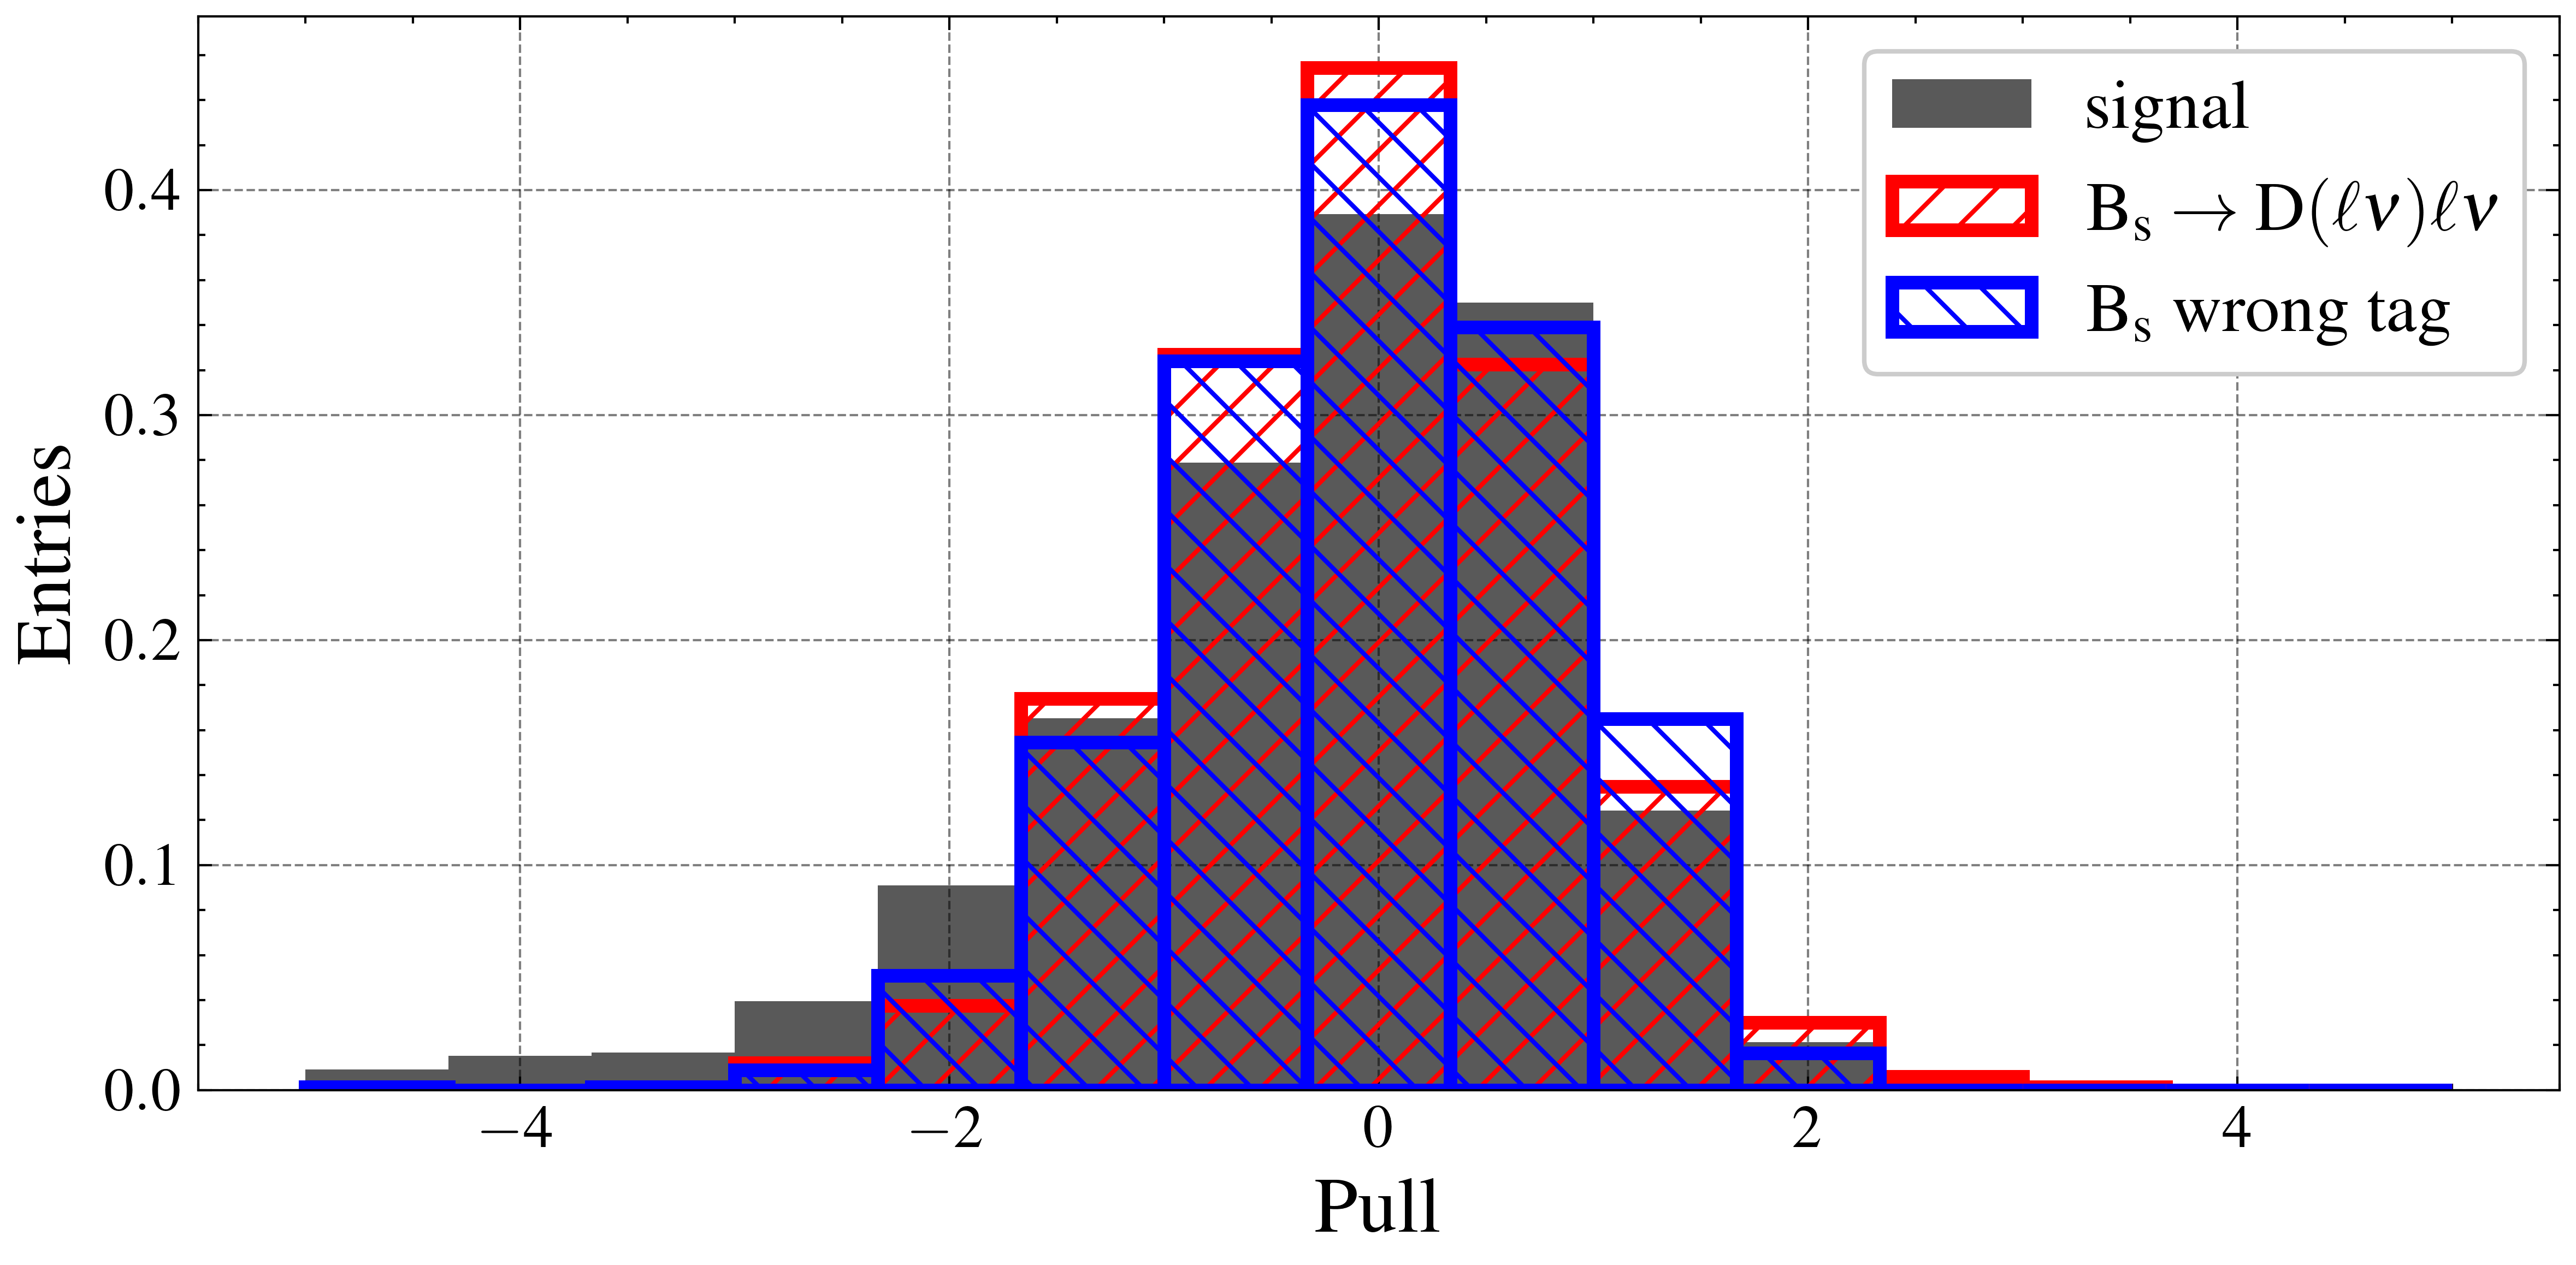

In [88]:
# --- анализ pull ---
A_array = np.array(A_list)
A_errors = np.array(A_errors)
bins = np.linspace(-5, 5, 16)

A0_true = 0
A1_true = N2/6
A2_true = N1/6

delta_signal = (A_array[:, 0] - A0_true) / A_errors[:, 0]
delta_bsb = (A_array[:, 1] - A1_true) / A_errors[:, 1]
delta_ubs = (A_array[:, 2]- A2_true) / A_errors[:, 2] 

counts_signal, bin_edges = np.histogram(delta_signal, bins=bins, density=True)
counts_bsb, _ = np.histogram(delta_bsb, bins=bins, density=True)
counts_ubs, _ = np.histogram(delta_ubs, bins=bins, density=True)

bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.bar(bin_centers, counts_signal, width=np.diff(bins), alpha=0.65, label=r"$\mathrm{signal}$", align='center')
plt.bar(bin_centers, counts_bsb, width=np.diff(bins), label=r"$\mathrm{B_s \to D(\ell \nu)\ell \nu}$",
        align='center', facecolor='none', edgecolor=colors[1], hatch='//', linewidth=3)
plt.bar(bin_centers, counts_ubs, width=np.diff(bins), label=r"$\mathrm{B_s \ wrong \ tag}$",
        align='center', facecolor='none', edgecolor=colors[2], hatch='\\\\', linewidth=3)

plt.xlabel(r"$\mathrm{Pull}$")
plt.ylabel(r"$\mathrm{Entries}$")
plt.legend()
plt.tight_layout()
plt.savefig(f"output/toy_err.pdf")
plt.show()

In [ ]:
(A_array[:, 0]+A_array[:, 1]+A_array[:, 2]) - N2/6 - N1/6

array([-1.16659369, -1.17011858, -1.16832647, -1.170249  , -1.17624009,
       -1.18155016, -1.15757648, -1.16851905, -1.16836215, -1.17703501,
       -1.16771508, -1.17547276, -1.09281689, -1.19518183,  0.        ,
       -1.17011684, -1.19660577, -1.22371969, -1.16827095, -1.16290071,
       -1.15773807, -1.16621724, -1.17062898, -1.17191203,  8.42305966,
       -1.14683828, -1.16271538, -1.14595358, -1.15032123, -1.18872291,
       -1.10262681, -1.16000487, -1.2047995 , -1.17266256, -1.19106282,
       -1.1655556 , -1.16661397, -1.17710985, -1.13956007, -1.16010614,
       -1.17094268, -1.17457653, -1.14468496, -1.16862696, -1.16436553,
       -1.13644562, -1.19808324, -1.17845124, -1.16819774, -1.16487574,
        0.        , -1.15679542, -1.16629766, -1.16455621, -1.13841297,
       -1.18887952, -1.11411231, -1.15882786, -1.16772745, -1.1650031 ,
       -1.19064531, -1.17573812, -1.136677  , -1.16907932, -1.16682498,
       -1.16495725, -1.15124579, -1.15144788, -1.13030998, -1.16

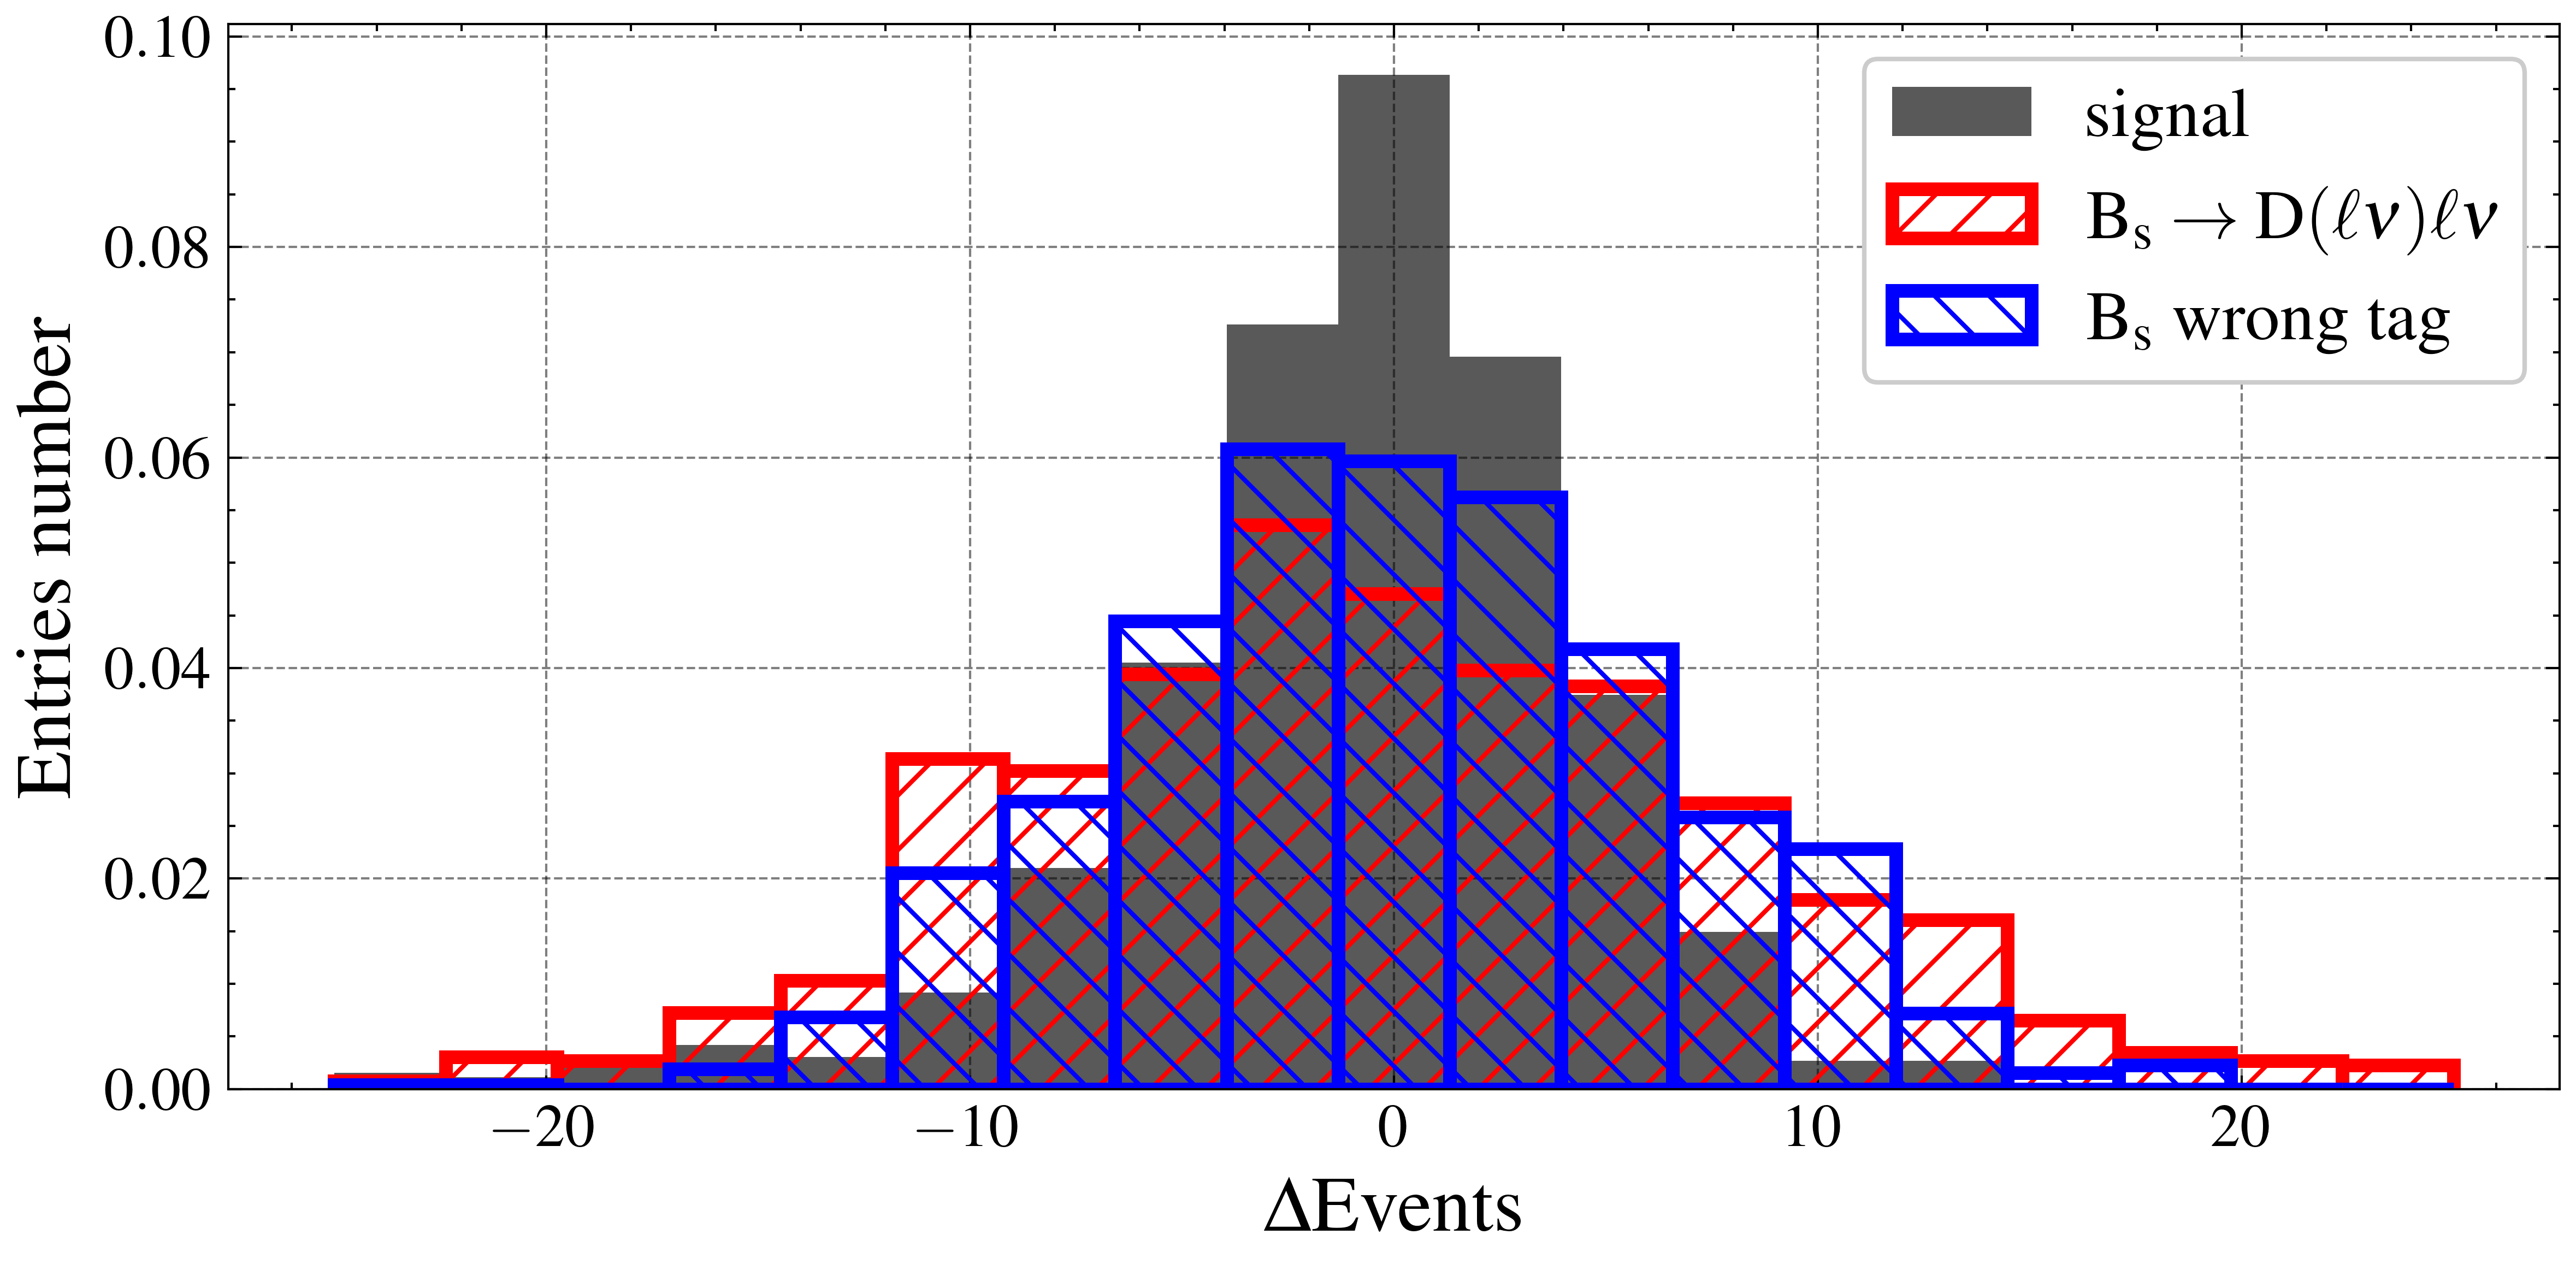

In [89]:
# --- анализ pull ---
A_array = np.array(A_list)
A_errors = np.array(A_errors)
bins = np.linspace(-25, 25, 20)

A0_true = 0
A1_true = N2/6
A2_true = N1/6

delta_signal = (A_array[:, 0] - A0_true)
delta_bsb = (A_array[:, 1] - A1_true)
delta_ubs = (A_array[:, 2]- A2_true)

counts_signal, bin_edges = np.histogram(delta_signal, bins=bins, density=True)
counts_bsb, _ = np.histogram(delta_bsb, bins=bins, density=True)
counts_ubs, _ = np.histogram(delta_ubs, bins=bins, density=True)

bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.bar(bin_centers, counts_signal, width=np.diff(bins), alpha=0.65, label=r"$\mathrm{signal}$", align='center')
plt.bar(bin_centers, counts_bsb, width=np.diff(bins), label=r"$\mathrm{B_s \to D(\ell \nu)\ell \nu}$",
        align='center', facecolor='none', edgecolor=colors[1], hatch='//', linewidth=3)
plt.bar(bin_centers, counts_ubs, width=np.diff(bins), label=r"$\mathrm{B_s \ wrong \ tag}$",
        align='center', facecolor='none', edgecolor=colors[2], hatch='\\\\', linewidth=3)

plt.xlabel(r"$\mathrm{\Delta Events}$")
plt.ylabel(r"$\mathrm{Entries \ number}$")
plt.legend()
plt.tight_layout()
plt.savefig(f"output/toy_err.pdf")
plt.show()

In [90]:
f_n_sig = (A_array[:, 0])
delta_signal = np.sort(A_array[:, 0])[int(len(f_n_sig)*0.95)]
print(delta_signal)

6.761351707501646


In [91]:
print(np.mean(A_array[:, 0]))


-1.0397760948285213
